
# Summary
We use the NHL API to pull information about standings, team performance for all the teams and use it to create a number of features that would be relevant in poredicting attendance ata sporting venue. Next, we do some exploratory data analysis to understand the distribution of features, independent variable, check for collinearity etc.
We then pre- processing and apply a simple multiple linear regression model. We then move on to using cross validation.
Next, we move on to regularized linear models. We then evaluate the performance of linear models with an ensemple method Random Forest. Deep diving into Random Forest to improve accuracies.



In [2]:

import requests
import json
import time
import pandas as pd
import numpy as np
import saspy
from datetime import *
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


Pulling league standings for the seasons 2017-2018 & 2018-2019

In [3]:

# dataframe with detailed standings information

s_date = ['2017-12-25', '2018-12-25']
s_year = ['20172018', '20182019']
team = []
for i in range(0,len(s_date)):
    
    url_standings = f'https://statsapi.web.nhl.com/api/v1/standings?date={s_date[i]}&expand=standings.record'
    # change the season value at the end of the cell based on the date used
    r = requests.get(url_standings)

    standings = r.json()

    for div_no in range(0,len(standings['records'])):
        for team_no in range(0,len(standings['records'][div_no]['teamRecords'])):
            inter = [standings['records'][div_no]['teamRecords'][team_no]['team']
                     .get(key) for key in ['id', 'name']]
            inter.extend([standings['records'][div_no]['teamRecords'][team_no]['leagueRecord']
                          .get(key) for key in ['wins','losses', 'ot']])
            inter.extend([standings['records'][div_no]['teamRecords'][team_no]
                     .get(key) for key in ['goalsAgainst', 'goalsScored','points','divisionRank','conferenceRank',
                                           'leagueRank','wildCardRank','lastUpdated']]) 
            inter.extend([standings['records'][div_no]['teamRecords'][team_no]['streak'].get('streakCode')])        
            inter.extend([standings['records'][div_no]['division'].get('name')])
            inter.extend([standings['records'][div_no]['conference'].get('name')])       
            for div_rec_no in range(0,len(standings['records'][div_no]['teamRecords'][team_no]['records']['divisionRecords'])):
                inter.extend([standings['records'][div_no]['teamRecords'][team_no]['records']['divisionRecords'][div_rec_no]
                          .get(key) for key in ['wins','losses', 'ot']])
            for conf_rec_no in range(0,len(standings['records'][div_no]['teamRecords'][team_no]['records']['conferenceRecords'])):
                inter.extend([standings['records'][div_no]['teamRecords'][team_no]['records']['conferenceRecords'][conf_rec_no]
                          .get(key) for key in ['wins','losses', 'ot']])            
            for ov_rec_no in range(0,len(standings['records'][div_no]['teamRecords'][team_no]['records']['overallRecords'])):
                inter.extend([standings['records'][div_no]['teamRecords'][team_no]['records']['overallRecords'][ov_rec_no]
                          .get(key) for key in ['wins','losses', 'ot']]) 
            inter.extend([s_year[i]])    
            team.append(inter)
#        standings_by_year.append(team)

    #team       
standings_df = pd.DataFrame(team) 


standings_df.columns = ['Team_id', 'Team_name', 'Wins', 'Losses', 'Overtime', 'GA', 'GF', 'Points', 'Rank_div',
                        'Rank_conf', 'Rank_league', 'Rank_wc', 'Last_updated', 'Streak', 'Division', 'Conference',
                        'div_c_wins', 'div_c_losses', 'div_c_ot', 'div_a_wins', 'div_a_losses', 'div_a_ot',
                        'div_p_wins', 'div_p_losses', 'div_p_ot', 'div_m_wins', 'div_m_losses', 'div_m_ot',
                        'conf_e_wins', 'conf_e_losses', 'conf_e_ot', 'conf_w_wins', 'conf_w_losses', 'conf_w_ot',
                        'ov_h_wins', 'ov_h_losses', 'ov_h_ot', 'ov_a_wins', 'ov_a_losses', 'ov_a_ot',
                        'ov_shoot_wins', 'ov_shoot_losses', 'ov_shoot_ot', 'ov_L10_wins', 'ov_L10_losses', 'ov_L10_ot',
                       'season']

standings_df.head()


,Team_id,Team_name,Wins,Losses,Overtime,GA,GF,Points,Rank_div,Rank_conf,...,ov_a_wins,ov_a_losses,ov_a_ot,ov_shoot_wins,ov_shoot_losses,ov_shoot_ot,ov_L10_wins,ov_L10_losses,ov_L10_ot,season
0,15,Washington Capitals,49,26,7,239,259,105,1,3,...,21,15,5,3,1,None,8,2,0,20172018
1,5,Pittsburgh Penguins,47,29,6,250,272,100,2,5,...,17,20,4,2,2,None,6,3,1,20172018
2,4,Philadelphia Flyers,42,26,14,243,251,98,3,6,...,20,13,8,2,7,None,6,1,3,20172018
3,29,Columbus Blue Jackets,45,30,7,230,242,97,4,7,...,19,18,4,6,4,None,6,2,2,20172018
4,1,New Jersey Devils,44,29,9,244,248,97,5,8,...,21,15,5,5,4,None,7,2,1,20172018


Next, we extract a list of team names with their corresponding team_ids

In [4]:

team = []

url = f'https://statsapi.web.nhl.com/api/v1/standings?season=20172018'

    
# #?season=20172018&
r = requests.get(url)

standings = r.json()

for div_no in range(0,len(standings['records'])):
    for team_no in range(0,len(standings['records'][div_no]['teamRecords'])):
        inter = [standings['records'][div_no]['teamRecords'][team_no]['team']
                 .get(key) for key in ['id', 'name']]
        team.append(inter)
        
team_df = pd.DataFrame(team)

team_df.columns = ['Team_id','Team_Name']

print(team)


[[15, 'Washington Capitals'], [5, 'Pittsburgh Penguins'], [4, 'Philadelphia Flyers'], [29, 'Columbus Blue Jackets'], [1, 'New Jersey Devils'], [12, 'Carolina Hurricanes'], [2, 'New York Islanders'], [3, 'New York Rangers'], [14, 'Tampa Bay Lightning'], [6, 'Boston Bruins'], [10, 'Toronto Maple Leafs'], [13, 'Florida Panthers'], [17, 'Detroit Red Wings'], [8, 'Montréal Canadiens'], [9, 'Ottawa Senators'], [7, 'Buffalo Sabres'], [18, 'Nashville Predators'], [52, 'Winnipeg Jets'], [30, 'Minnesota Wild'], [21, 'Colorado Avalanche'], [19, 'St. Louis Blues'], [25, 'Dallas Stars'], [16, 'Chicago Blackhawks'], [54, 'Vegas Golden Knights'], [24, 'Anaheim Ducks'], [28, 'San Jose Sharks'], [26, 'Los Angeles Kings'], [20, 'Calgary Flames'], [22, 'Edmonton Oilers'], [23, 'Vancouver Canucks'], [53, 'Arizona Coyotes']]


Extracting the team_ids for Boston Bruins, Buffalo Sabres, Columbus Blue Jackets, Detroit Red Wings, Nashville Predators and Tampa Bay Lightning

In [5]:

id_list = []

for no_1 in range(0,len(team)):
    team_name = team[no_1]
    if team_name[1] in ('Boston Bruins', 'Buffalo Sabres', 'Columbus Blue Jackets', 
                           'Detroit Red Wings', 'Nashville Predators', 'Tampa Bay Lightning'):
        id_list.append(team_name[0])
    
print(id_list) 

[29, 14, 6, 17, 7, 18]


Pulling the team performance statistics for the above 6 teams for seasons 2017-2018 & 2018-2019

In [6]:

# team stats for 2 seasons

st_end_date = np.reshape(['2017-10-01', '2018-04-30',
               '2018-10-01', '2019-04-30'],(2,2))
stat_data = []

for i in range(0,2):
    for id_no in range(0,len(id_list)):
        url_stats = f'https://statsapi.web.nhl.com/api/v1/schedule?teamId={id_list[id_no]}&startDate={st_end_date[i,0]}&endDate={st_end_date[i,1]}&expand=schedule.linescore'

        r = requests.get(url_stats)
        game_stats = r.json()
        #game_stats

        for date_no in range(0,len(game_stats['dates'])):
            inter = [game_stats['dates'][date_no]['games'][0]
                     .get(key) for key in ['gamePk', 'season', 'gameDate','gameType']]
            inter.extend([game_stats['dates'][date_no]['games'][0]['teams']['home']['leagueRecord']
                         .get(key) for key in ['wins','losses','ot']])
            inter.extend([game_stats['dates'][date_no]['games'][0]['teams']['away']['leagueRecord']
                         .get(key) for key in ['wins','losses','ot']])
            inter.extend([game_stats['dates'][date_no]['games'][0]['linescore']['teams']['home']['team']
                          .get(key) for key in ['id','name']])
            inter.extend([game_stats['dates'][date_no]['games'][0]['linescore']['teams']['home']
                          .get(key) for key in ['goals','shotsOnGoal','goaliePulled','numSkaters','powerPlay']])    
            inter.extend([game_stats['dates'][date_no]['games'][0]['linescore']['teams']['away']['team']
                          .get(key) for key in ['id','name']])
            inter.extend([game_stats['dates'][date_no]['games'][0]['linescore']['teams']['away']
                          .get(key) for key in ['goals','shotsOnGoal','goaliePulled','numSkaters','powerPlay']])        
            inter.append
            stat_data.append(inter)

    #stat_data

    match_statistics_df = pd.DataFrame(stat_data)


    match_statistics_df.columns = ['Game_id','Season','Date','gameType','h_wins','h_losses','h_ot','a_wins','a_losses',
                                   'a_ot','h_id','h_team','h_team_goals','h_shotsOnGoal','h_goaliePulled','h_numSkaters',
                                   'h_powerPlay','a_id','a_team','a_team_goals','a_shotsOnGoal','a_goaliePulled',
                                   'a_numSkaters','a_powerPlay']

match_statistics_df.sort_values(by=['h_team','Date'])

# extracting date from date series object

match_statistics_df['true_date'] = pd.to_datetime(match_statistics_df['Date'])

match_statistics_df['true_date'] = match_statistics_df['true_date'].dt.date

match_statistics_df.head()


,Game_id,Season,Date,gameType,h_wins,h_losses,h_ot,a_wins,a_losses,a_ot,...,h_numSkaters,h_powerPlay,a_id,a_team,a_team_goals,a_shotsOnGoal,a_goaliePulled,a_numSkaters,a_powerPlay,true_date
0,2017020013,20172018,2017-10-06T23:00:00Z,R,1,0,0.0,0,1,0.0,...,5,False,2,New York Islanders,0,29,False,5,False,2017-10-06
1,2017020025,20172018,2017-10-08T00:30:00Z,R,2,0,0.0,1,1,0.0,...,5,False,29,Columbus Blue Jackets,1,33,False,5,False,2017-10-08
2,2017020040,20172018,2017-10-10T23:00:00Z,R,1,0,1.0,2,1,0.0,...,3,False,29,Columbus Blue Jackets,2,27,False,3,False,2017-10-10
3,2017020059,20172018,2017-10-13T23:00:00Z,R,3,1,0.0,1,4,0.0,...,5,False,3,New York Rangers,1,38,False,5,False,2017-10-13
4,2017020070,20172018,2017-10-15T00:00:00Z,R,1,1,2.0,4,1,0.0,...,3,False,29,Columbus Blue Jackets,5,35,False,3,False,2017-10-15


In [7]:

match_statistics_df.shape


(1041, 25)

In [8]:

match_statistics_df['true_date'] = pd.to_datetime(match_statistics_df['Date'])

match_statistics_df.true_date.dtypes


datetime64[ns, UTC]

Dropping the unwanted columns and duplicate entries

In [9]:

columns=['h_goaliePulled','h_numSkaters','h_powerPlay','a_goaliePulled','a_numSkaters','a_powerPlay']

match_statistics_df.drop(columns, inplace=True, axis=1)

match_statistics_df = match_statistics_df.drop_duplicates()

match_statistics_df.head()


,Game_id,Season,Date,gameType,h_wins,h_losses,h_ot,a_wins,a_losses,a_ot,h_id,h_team,h_team_goals,h_shotsOnGoal,a_id,a_team,a_team_goals,a_shotsOnGoal,true_date
0,2017020013,20172018,2017-10-06T23:00:00Z,R,1,0,0.0,0,1,0.0,29,Columbus Blue Jackets,5,37,2,New York Islanders,0,29,2017-10-06 23:00:00+00:00
1,2017020025,20172018,2017-10-08T00:30:00Z,R,2,0,0.0,1,1,0.0,16,Chicago Blackhawks,5,29,29,Columbus Blue Jackets,1,33,2017-10-08 00:30:00+00:00
2,2017020040,20172018,2017-10-10T23:00:00Z,R,1,0,1.0,2,1,0.0,12,Carolina Hurricanes,1,38,29,Columbus Blue Jackets,2,27,2017-10-10 23:00:00+00:00
3,2017020059,20172018,2017-10-13T23:00:00Z,R,3,1,0.0,1,4,0.0,29,Columbus Blue Jackets,3,43,3,New York Rangers,1,38,2017-10-13 23:00:00+00:00
4,2017020070,20172018,2017-10-15T00:00:00Z,R,1,1,2.0,4,1,0.0,30,Minnesota Wild,4,21,29,Columbus Blue Jackets,5,35,2017-10-15 00:00:00+00:00


In [11]:

match_stats_with_id = pd.DataFrame(columns=['Game_id','Season','Date','gameType','h_wins','h_losses','h_ot','a_wins',
                                            'a_losses','a_ot','h_id','h_team','h_team_goals','h_shotsOnGoal',
                                            'a_id','a_team','a_team_goals','a_shotsOnGoal','true_date','team_name'])


for name in ('Boston Bruins', 'Buffalo Sabres', 'Columbus Blue Jackets', 
                           'Detroit Red Wings', 'Nashville Predators', 'Tampa Bay Lightning'):
    team_stats_with_id = match_statistics_df[(match_statistics_df.h_team == name) 
                                     | (match_statistics_df.a_team == name)].sort_values(by='Date')

    team_stats_with_id['team_name'] = name

    match_stats_with_id = match_stats_with_id.append(team_stats_with_id)


match_stats_with_id = match_stats_with_id.sort_values(['team_name', 'Date'])

match_stats_with_id.head()


,Game_id,Season,Date,gameType,h_wins,h_losses,h_ot,a_wins,a_losses,a_ot,h_id,h_team,h_team_goals,h_shotsOnGoal,a_id,a_team,a_team_goals,a_shotsOnGoal,true_date,team_name
177,2017020005,20172018,2017-10-05T23:00:00Z,R,1,0,0.0,0,1,0.0,6,Boston Bruins,4,32,18,Nashville Predators,3,29,2017-10-05 23:00:00+00:00,Boston Bruins
178,2017020032,20172018,2017-10-09T17:00:00Z,R,1,1,0.0,2,1,0.0,6,Boston Bruins,0,29,21,Colorado Avalanche,4,23,2017-10-09 17:00:00+00:00,Boston Bruins
179,2017020048,20172018,2017-10-12T01:30:00Z,R,3,1,0.0,1,2,0.0,21,Colorado Avalanche,6,37,6,Boston Bruins,3,23,2017-10-12 01:30:00+00:00,Boston Bruins
180,2017020072,20172018,2017-10-15T01:00:00Z,R,0,4,1.0,2,2,0.0,53,Arizona Coyotes,2,31,6,Boston Bruins,6,29,2017-10-15 01:00:00+00:00,Boston Bruins
181,2017020077,20172018,2017-10-15T23:00:00Z,R,4,1,0.0,2,3,0.0,54,Vegas Golden Knights,3,26,6,Boston Bruins,1,22,2017-10-15 23:00:00+00:00,Boston Bruins


In [12]:
match_stats_with_id.shape

(1041, 20)

In [13]:

# Adding division and conference info to the dataframe

match_stats_with_id.dtypes


Game_id           object
Season            object
Date              object
gameType          object
h_wins            object
h_losses          object
h_ot             float64
a_wins            object
a_losses          object
a_ot             float64
h_id              object
h_team            object
h_team_goals      object
h_shotsOnGoal     object
a_id              object
a_team            object
a_team_goals      object
a_shotsOnGoal     object
true_date         object
team_name         object
dtype: object

Calculating rolling average stats for home matches

In [14]:

pd.options.display.max_columns = None

# Calculating average stats for home team from match_stats_with_id dataframe

seasons = ['20172018', '20182019']

team_list = ['Boston Bruins', 'Buffalo Sabres', 'Columbus Blue Jackets', 
             'Detroit Red Wings','Nashville Predators', 'Tampa Bay Lightning']

team_stats_all = pd.DataFrame(columns=['Game_id','Season','Date','gameType','h_wins','h_losses','h_ot','a_wins',
                                            'a_losses','a_ot','h_id','h_team','h_team_goals','h_shotsOnGoal',
                                            'a_id','a_team','a_team_goals','a_shotsOnGoal','true_date','team_name',
                                  'avg_h_goals','avg_h_sog','avg_a_goals','avg_a_sog'])
for i in range(0,2):

    for tn in team_list:
        team_stats = match_stats_with_id[(match_stats_with_id['h_team'] == tn) & (match_stats_with_id['team_name'] == tn) &
                                        (match_stats_with_id['Season'] == seasons[i])]

        team_stats['avg_h_goals'] = team_stats['h_team_goals'].expanding(1).mean()
        team_stats['avg_h_sog'] = team_stats['h_shotsOnGoal'].expanding(1).mean()
        team_stats['avg_a_goals'] = team_stats['a_team_goals'].expanding(1).mean()
        team_stats['avg_a_sog'] = team_stats['a_shotsOnGoal'].expanding(1).mean()
        team_stats_all = team_stats_all.append(team_stats)

team_performance_data = team_stats_all

team_performance_data.head()


D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,Game_id,Season,Date,gameType,h_wins,h_losses,h_ot,a_wins,a_losses,a_ot,h_id,h_team,h_team_goals,h_shotsOnGoal,a_id,a_team,a_team_goals,a_shotsOnGoal,true_date,team_name,avg_h_goals,avg_h_sog,avg_a_goals,avg_a_sog
177,2017020005,20172018,2017-10-05T23:00:00Z,R,1,0,0.0,0,1,0.0,6,Boston Bruins,4,32,18,Nashville Predators,3,29,2017-10-05 23:00:00+00:00,Boston Bruins,4.000000,32.00,3.000000,29.00
178,2017020032,20172018,2017-10-09T17:00:00Z,R,1,1,0.0,2,1,0.0,6,Boston Bruins,0,29,21,Colorado Avalanche,4,23,2017-10-09 17:00:00+00:00,Boston Bruins,2.000000,30.50,3.500000,26.00
182,2017020095,20172018,2017-10-19T23:00:00Z,R,3,3,0.0,2,3,1.0,6,Boston Bruins,6,35,23,Vancouver Canucks,3,29,2017-10-19 23:00:00+00:00,Boston Bruins,3.333333,32.00,3.333333,27.00
183,2017020112,20172018,2017-10-21T23:00:00Z,R,3,3,1.0,2,5,2.0,6,Boston Bruins,4,31,7,Buffalo Sabres,5,42,2017-10-21 23:00:00+00:00,Boston Bruins,3.500000,31.75,3.750000,30.75
184,2017020138,20172018,2017-10-26T23:00:00Z,R,4,3,1.0,4,5,0.0,6,Boston Bruins,2,33,28,San Jose Sharks,1,37,2017-10-26 23:00:00+00:00,Boston Bruins,3.200000,32.00,3.200000,32.00


Calculating head to head stats against all opposition teams for seasons 2017-2018 & 2018-2019

In [15]:

# Calculating head to head stats from match_stats_with_id dataframe

seasons = ['20172018', '20182019']

hth_stats_all = pd.DataFrame(columns=['Game_id','Season','Date','gameType','h_wins','h_losses','h_ot','a_wins',
                                            'a_losses','a_ot','h_id','h_team','h_team_goals','h_shotsOnGoal',
                                            'a_id','a_team','a_team_goals','a_shotsOnGoal','true_date','team_name',
                                     'win_team','Win','hth_wins','hth_avg_gc','hth_gd','hth_avg_gd'])


team_list = ['Boston Bruins', 'Buffalo Sabres', 'Columbus Blue Jackets', 
             'Detroit Red Wings', 'Nashville Predators', 'Tampa Bay Lightning']

for i in range(0,2):

    for t_name in team_list:

        # updating the opp_team_list for each of our team
        opp_team_list = []
        for no_1 in range(0,len(team)):
            team_name = team[no_1]
            if team_name[1] != t_name:
                opp_team_list.append(team_name[1])

        for opp_t in opp_team_list:
            hth_stats = match_stats_with_id[(match_stats_with_id.team_name == t_name) & 
                                                ((match_stats_with_id.h_team == opp_t)| 
                                                 (match_stats_with_id.a_team == opp_t)) &
                                           (match_stats_with_id['Season'] == seasons[i])].sort_values(by='Date')

            hth_stats.loc[hth_stats['h_team_goals'] > hth_stats['a_team_goals'], 'win_team'] = hth_stats['h_team']
            hth_stats.loc[hth_stats['h_team_goals'] < hth_stats['a_team_goals'], 'win_team'] = hth_stats['a_team']
            hth_stats.loc[(hth_stats['h_team_goals'] > hth_stats['a_team_goals']) &
                          (hth_stats['h_team'] == hth_stats['team_name']), 'Win'] = 1
            hth_stats.loc[(hth_stats['h_team_goals'] < hth_stats['a_team_goals']) &
                          (hth_stats['a_team'] == hth_stats['team_name']), 'Win'] = 1
            hth_stats.loc[(hth_stats['h_team_goals'] > hth_stats['a_team_goals']) &
                          (hth_stats['a_team'] == hth_stats['team_name']), 'Win'] = 0
            hth_stats.loc[(hth_stats['h_team_goals'] < hth_stats['a_team_goals']) &
                          (hth_stats['h_team'] == hth_stats['team_name']), 'Win'] = 0
            hth_stats['hth_wins'] = (hth_stats['Win'].expanding(1).sum())
            hth_stats['hth_avg_gc'] = (hth_stats['h_team_goals'] + hth_stats['a_team_goals']).expanding(1).mean()

            hth_stats.loc[hth_stats['h_team'] == t_name, 'hth_gd'] = (hth_stats['h_team_goals'] - 
                                                                          hth_stats['a_team_goals'])
            #.expanding(1).mean()
            hth_stats.loc[hth_stats['a_team'] == t_name, 'hth_gd'] = (hth_stats['a_team_goals'] - 
                                                                          hth_stats['h_team_goals'])
            hth_stats['hth_avg_gd'] = hth_stats['hth_gd'].expanding(1).mean()
            #.expanding(1).mean()
            hth_stats_all = hth_stats_all.append(hth_stats)

columns = ['Date','h_wins','h_losses','h_ot','a_wins','a_losses','a_ot','h_id','a_id','hth_gd']

hth_stats_all.drop(columns, inplace=True, axis=1)

hth_stats_all = hth_stats_all.drop_duplicates()
hth_stats_all.head()


,Game_id,Season,gameType,h_team,h_team_goals,h_shotsOnGoal,a_team,a_team_goals,a_shotsOnGoal,true_date,team_name,win_team,Win,hth_wins,hth_avg_gc,hth_avg_gd
188,2017020201,20172018,R,Boston Bruins,2,33,Washington Capitals,3,27,2017-11-04 23:00:00+00:00,Boston Bruins,Washington Capitals,0.0,0.0,5.000000,-1.000000
205,2017020479,20172018,R,Boston Bruins,3,37,Washington Capitals,5,22,2017-12-15 00:00:00+00:00,Boston Bruins,Washington Capitals,0.0,0.0,6.500000,-1.500000
212,2017020569,20172018,R,Washington Capitals,4,34,Boston Bruins,3,34,2017-12-29 00:30:00+00:00,Boston Bruins,Washington Capitals,0.0,0.0,6.666667,-1.333333
197,2017020334,20172018,R,Boston Bruins,4,33,Pittsburgh Penguins,3,20,2017-11-24 18:00:00+00:00,Boston Bruins,Boston Bruins,1.0,1.0,7.000000,1.000000
216,2017020650,20172018,R,Pittsburgh Penguins,6,35,Boston Bruins,5,25,2018-01-08 00:30:00+00:00,Boston Bruins,Pittsburgh Penguins,0.0,1.0,9.000000,0.000000


In [16]:
hth_stats_all.shape

(1041, 16)

Reading the attendance data

In [17]:

# Joining turnstile data

attendance = pd.read_excel('Turnstile_data.xlsx')

attendance.loc[attendance['Location'] == 'TD Garden', 'Team_Name'] = 'Boston Bruins'
attendance.loc[attendance['Location'] == 'Key Bank Center', 'Team_Name'] = 'Buffalo Sabres'
attendance.loc[attendance['Location'] == 'Little Caesars', 'Team_Name'] = 'Detroit Red Wings'
attendance.loc[attendance['Location'] == 'Nashville', 'Team_Name'] = 'Nashville Predators'
attendance.loc[attendance['Location'] == 'Nationwide', 'Team_Name'] = 'Columbus Blue Jackets'
attendance.loc[attendance['Location'] == 'Tampa', 'Team_Name'] = 'Tampa Bay Lightning'

attendance.head()


,Date,Project,Event,Attendance,Location,Team_Name
0,2017-10-05,NHLRG,Vs Nashville,16258,TD Garden,Boston Bruins
1,2017-10-09,NHLRG,Vs Colorado,15881,TD Garden,Boston Bruins
2,2017-10-19,NHLRG,Vs Vancouver,15152,TD Garden,Boston Bruins
3,2017-10-21,NHLRG,Vs Buffalo,16152,TD Garden,Boston Bruins
4,2017-10-26,NHLRG,Vs San Jose,15367,TD Garden,Boston Bruins


Merging the standings and division information of the home and away teams to the head to head stats dataframe

In [18]:


standings = standings_df[['Team_name','Rank_league','Division','Conference','season']]

#standings

hth_stats_all_1 = hth_stats_all.merge(standings, left_on=['h_team','Season'], right_on=['Team_name','season'], how='left')

hth_stats_all_1 = hth_stats_all_1.drop(columns={'Team_name','season'})
hth_stats_all_2 = hth_stats_all_1.rename(columns={'Rank_league':'h_team_rank','Division':'h_div',
                                             'Conference':'h_conf'})


hth_stats_all_3 = hth_stats_all_2.merge(standings, left_on=['a_team','Season'], right_on=['Team_name','season'], how='left')
hth_stats_all_3 = hth_stats_all_3.drop(columns={'Team_name','season'})

hth_stats_all_4 = hth_stats_all_3.rename(columns={'Rank_league':'a_team_rank','Division':'a_div',
                                             'Conference':'a_conf'})


hth_stats_all_4.columns


Index(['Game_id', 'Season', 'gameType', 'h_team', 'h_team_goals',
       'h_shotsOnGoal', 'a_team', 'a_team_goals', 'a_shotsOnGoal', 'true_date',
       'team_name', 'win_team', 'Win', 'hth_wins', 'hth_avg_gc', 'hth_avg_gd',
       'h_team_rank', 'h_div', 'h_conf', 'a_team_rank', 'a_div', 'a_conf'],
      dtype='object')

Creating a flag to identify if the home and away teams are in the same division, same conference or different conference

In [19]:

hth_stats_all_4.loc[(hth_stats_all_4['h_div'] == hth_stats_all_4['a_div']), 'league_type'] = 'same_division'
hth_stats_all_4.loc[(hth_stats_all_4['h_div'] != hth_stats_all_4['a_div'])
                    & (hth_stats_all_4['h_conf'] == hth_stats_all_4['a_conf']), 'league_type'] = 'same_conference'
hth_stats_all_4.loc[(hth_stats_all_4['h_div'] != hth_stats_all_4['a_div'])
                    & (hth_stats_all_4['h_conf'] != hth_stats_all_4['a_conf']), 'league_type'] = 'different_conference'

hth_stats_all_4.head()


,Game_id,Season,gameType,h_team,h_team_goals,h_shotsOnGoal,a_team,a_team_goals,a_shotsOnGoal,true_date,team_name,win_team,Win,hth_wins,hth_avg_gc,hth_avg_gd,h_team_rank,h_div,h_conf,a_team_rank,a_div,a_conf,league_type
0,2017020201,20172018,R,Boston Bruins,2,33,Washington Capitals,3,27,2017-11-04 23:00:00+00:00,Boston Bruins,Washington Capitals,0.0,0.0,5.000000,-1.000000,4,Atlantic,Eastern,6,Metropolitan,Eastern,same_conference
1,2017020479,20172018,R,Boston Bruins,3,37,Washington Capitals,5,22,2017-12-15 00:00:00+00:00,Boston Bruins,Washington Capitals,0.0,0.0,6.500000,-1.500000,4,Atlantic,Eastern,6,Metropolitan,Eastern,same_conference
2,2017020569,20172018,R,Washington Capitals,4,34,Boston Bruins,3,34,2017-12-29 00:30:00+00:00,Boston Bruins,Washington Capitals,0.0,0.0,6.666667,-1.333333,6,Metropolitan,Eastern,4,Atlantic,Eastern,same_conference
3,2017020334,20172018,R,Boston Bruins,4,33,Pittsburgh Penguins,3,20,2017-11-24 18:00:00+00:00,Boston Bruins,Boston Bruins,1.0,1.0,7.000000,1.000000,4,Atlantic,Eastern,10,Metropolitan,Eastern,same_conference
4,2017020650,20172018,R,Pittsburgh Penguins,6,35,Boston Bruins,5,25,2018-01-08 00:30:00+00:00,Boston Bruins,Pittsburgh Penguins,0.0,1.0,9.000000,0.000000,10,Metropolitan,Eastern,4,Atlantic,Eastern,same_conference


Exporting dataframes to SAS datasets

In [23]:
mysas = saspy.SASsession(cfgname='iomwin')

Please enter the IOM user id: psanghvi
Please enter the password for IOM user : ········
SAS Connection established. Subprocess id is 7480



In [728]:
mysas.df2sd(hth_stats_all_4,table='ps_ss_nhl_check', libref="LC_COANL")

Libref  = LC_COANL
Table   = ps_ss_nhl_check
Dsopts  = {}
Results = Pandas

In [730]:

mysas.df2sd(hth_stats_all_4,table='ps_ss_head_to_head', libref="LC_COANL")


Libref  = LC_COANL
Table   = ps_ss_head_to_head
Dsopts  = {}
Results = Pandas

In [731]:

mysas.df2sd(team_performance_data,table='PS_SS_NHL_TEAM_PERFORMANCE', libref="LC_COANL")


Libref  = LC_COANL
Table   = PS_SS_NHL_TEAM_PERFORMANCE
Dsopts  = {}
Results = Pandas

In [732]:

mysas.df2sd(standings_df,table='PS_SS_NHL_TEAM_STANDINGS', libref="LC_COANL")


Libref  = LC_COANL
Table   = PS_SS_NHL_TEAM_STANDINGS
Dsopts  = {}
Results = Pandas

In [733]:

mysas.df2sd(attendance,table='PS_SS_NHL_ATTENDANCE', libref="LC_COANL")



Libref  = LC_COANL
Table   = PS_SS_NHL_ATTENDANCE
Dsopts  = {}
Results = Pandas

# Importing final SAS dataset for pre-processing before training the model

In [24]:

final = mysas.sd2df(table='PS_SS_WFM_FINAL', libref="LC_COANL")


In [25]:
final.head()

,event_date,month_number,day,Special_event_flag,Team_name,h_team,avg_h_goals,avg_h_sog,a_team,avg_a_goals,avg_a_sog,Season,gameType,hth_wins,hth_avg_gc,hth_avg_gd,league_type,Attendance,Weekend_flag,Day_game_flag
0,2017-10-05,10,5,0,Buffalo Sabres,Buffalo Sabres,2.00,45.000000,Montréal Canadiens,3.000000,40.000000,20172018,R,0,5.0,-1.0,same_division,17285,0,0
1,2017-10-09,10,2,1,Buffalo Sabres,Buffalo Sabres,2.00,35.000000,New Jersey Devils,4.500000,35.500000,20172018,R,0,8.0,-4.0,same_conference,14900,0,1
2,2017-10-20,10,6,0,Buffalo Sabres,Buffalo Sabres,2.00,30.666667,Vancouver Canucks,4.333333,37.333333,20172018,R,0,6.0,-2.0,different_conference,15715,1,0
3,2017-10-24,10,3,0,Buffalo Sabres,Buffalo Sabres,1.75,31.000000,Detroit Red Wings,3.250000,36.000000,20172018,R,1,1.0,1.0,same_division,14417,0,0
4,2017-10-28,10,7,0,Buffalo Sabres,Buffalo Sabres,1.80,31.400000,San Jose Sharks,3.200000,35.000000,20172018,R,0,5.0,-1.0,different_conference,16088,1,1


One hot encoding the categorical variables

In [26]:

final['opp_team'] = pd.Categorical(final['a_team'])
final['team'] = pd.Categorical(final['h_team'])
final['game'] = pd.Categorical(final['gameType'])
final['league'] = pd.Categorical(final['league_type'])
final['season'] = pd.Categorical(final['Season'])
final['month'] = pd.Categorical(final['month_number'])
final['weekday'] = pd.Categorical(final['day'])

final_1 = pd.get_dummies(final['opp_team'], prefix = 'opp', drop_first= True)
final_2 = pd.get_dummies(final['team'], prefix = 'home', drop_first= True)
final_3 = pd.get_dummies(final['game'], prefix = 'gametype', drop_first= True)
final_4 = pd.get_dummies(final['league'], drop_first= True)
final_5 = pd.get_dummies(final['season'], prefix = 'season', drop_first= True)
final_6 = pd.get_dummies(final['month'], prefix = 'month', drop_first= True)
final_7 = pd.get_dummies(final['weekday'], prefix = 'weekday', drop_first= True)

final_8 = pd.concat([final, final_1, final_2, final_3, final_4, final_5, final_6, final_7], axis = 1)

columns = ['event_date','h_team', 'a_team', 'Team_name', 'gameType','team', 'opp_team', 'game', 'league_type', 'league',
           'Season', 'season', 'month_number', 'month', 'day', 'weekday']

final_8.drop(columns, inplace=True, axis=1)

final_8.head()


,Special_event_flag,avg_h_goals,avg_h_sog,avg_a_goals,avg_a_sog,hth_wins,hth_avg_gc,hth_avg_gd,Attendance,Weekend_flag,Day_game_flag,opp_Arizona Coyotes,opp_Boston Bruins,opp_Buffalo Sabres,opp_Calgary Flames,opp_Carolina Hurricanes,opp_Chicago Blackhawks,opp_Colorado Avalanche,opp_Columbus Blue Jackets,opp_Dallas Stars,opp_Detroit Red Wings,opp_Edmonton Oilers,opp_Florida Panthers,opp_Los Angeles Kings,opp_Minnesota Wild,opp_Montréal Canadiens,opp_Nashville Predators,opp_New Jersey Devils,opp_New York Islanders,opp_New York Rangers,opp_Ottawa Senators,opp_Philadelphia Flyers,opp_Pittsburgh Penguins,opp_San Jose Sharks,opp_St. Louis Blues,opp_Tampa Bay Lightning,opp_Toronto Maple Leafs,opp_Vancouver Canucks,opp_Vegas Golden Knights,opp_Washington Capitals,opp_Winnipeg Jets,home_Buffalo Sabres,home_Columbus Blue Jackets,home_Detroit Red Wings,home_Nashville Predators,home_Tampa Bay Lightning,gametype_R,same_conference,same_division,season_20182019,month_2,month_3,month_4,month_10,month_11,month_12,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,0,2.00,45.000000,3.000000,40.000000,0,5.0,-1.0,17285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,2.00,35.000000,4.500000,35.500000,0,8.0,-4.0,14900,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0,2.00,30.666667,4.333333,37.333333,0,6.0,-2.0,15715,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,0,1.75,31.000000,3.250000,36.000000,1,1.0,1.0,14417,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0,1.80,31.400000,3.200000,35.000000,0,5.0,-1.0,16088,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [27]:
final_8.shape

(522, 62)

# Checking for missing values

In [28]:

for col in final_8:
    var = final_8[col].isna().sum()
    print(col, ":", var)


Special_event_flag : 0
avg_h_goals : 0
avg_h_sog : 0
avg_a_goals : 0
avg_a_sog : 0
hth_wins : 0
hth_avg_gc : 0
hth_avg_gd : 0
Attendance : 0
Weekend_flag : 0
Day_game_flag : 0
opp_Arizona Coyotes : 0
opp_Boston Bruins : 0
opp_Buffalo Sabres : 0
opp_Calgary Flames : 0
opp_Carolina Hurricanes : 0
opp_Chicago Blackhawks : 0
opp_Colorado Avalanche : 0
opp_Columbus Blue Jackets : 0
opp_Dallas Stars : 0
opp_Detroit Red Wings : 0
opp_Edmonton Oilers : 0
opp_Florida Panthers : 0
opp_Los Angeles Kings : 0
opp_Minnesota Wild : 0
opp_Montréal Canadiens : 0
opp_Nashville Predators : 0
opp_New Jersey Devils : 0
opp_New York Islanders : 0
opp_New York Rangers : 0
opp_Ottawa Senators : 0
opp_Philadelphia Flyers : 0
opp_Pittsburgh Penguins : 0
opp_San Jose Sharks : 0
opp_St. Louis Blues : 0
opp_Tampa Bay Lightning : 0
opp_Toronto Maple Leafs : 0
opp_Vancouver Canucks : 0
opp_Vegas Golden Knights : 0
opp_Washington Capitals : 0
opp_Winnipeg Jets : 0
home_Buffalo Sabres : 0
home_Columbus Blue Jackets : 

In [29]:

#for col in final_8:
#    print(final_8[col].value_counts(dropna=False))


# Linear Regression

Linear Regression Assumptions
    
1. Linear Relationship
2. Multivariate Normality (All variables)
3. No or little Collinearity
4. No auto correlation
5. Homoscedasticity

1. Linear Relationship
Relation between dependent and independent variable is linear or non linear
Best tested with scatter plots

2. Multivariate Normality
Best checked with histogram or a Q-Q plot

3. Multi Collinearity
can be tested with 3 ideas
correlation matrix, tolerance, Variance inflation factor

4.
occurs when residuals are not independent from each other

5.
Residuals are equal across the regression line



# Plotting scatter plots for continuous features to check for relationship with target variable


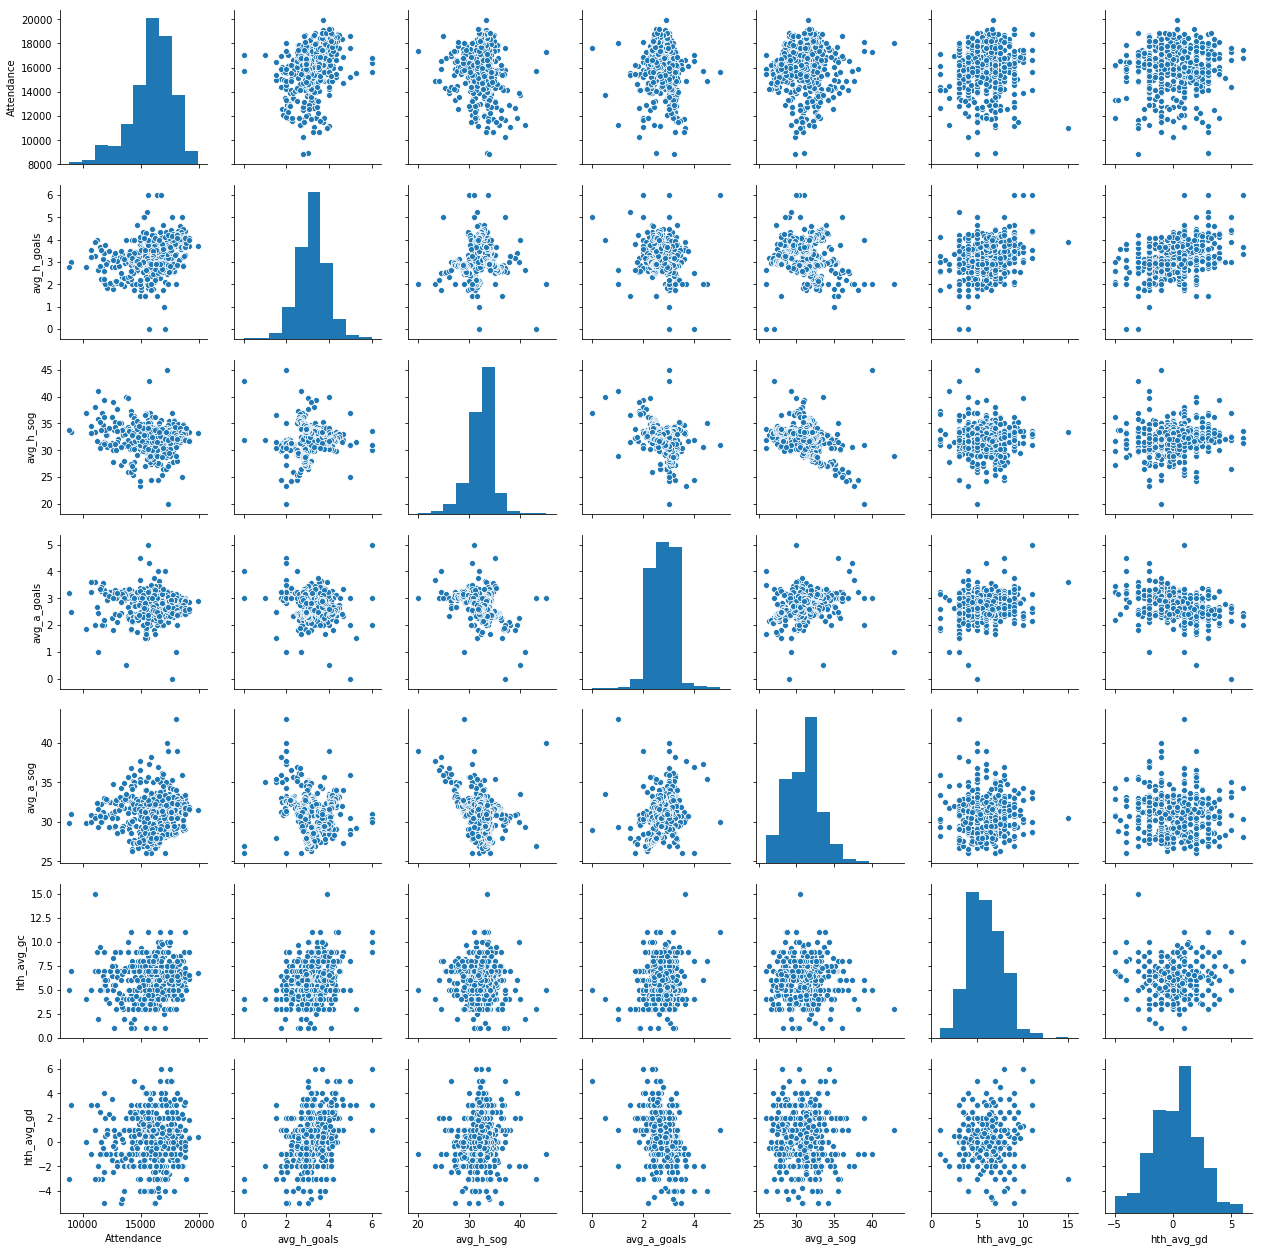

In [31]:

pairplot_data = final_8[['Attendance', 'avg_h_goals', 'avg_h_sog', 'avg_a_goals', 'avg_a_sog',
                         'hth_avg_gc', 'hth_avg_gd']]


sns.pairplot(pairplot_data)


Looking at the pairplots for continuous features, we notice that we can't visually see a lnear relation of all features with the attendance.
This could mean that the variable don't have a linear relation with the target variable.

# Plotting the correlation between features to check for collinearity

In [30]:
# Using pearson correlation
pd.options.display.max_columns = None

cor = final_8.corr()

cor.style.background_gradient(cmap = 'coolwarm' ).set_precision(2)


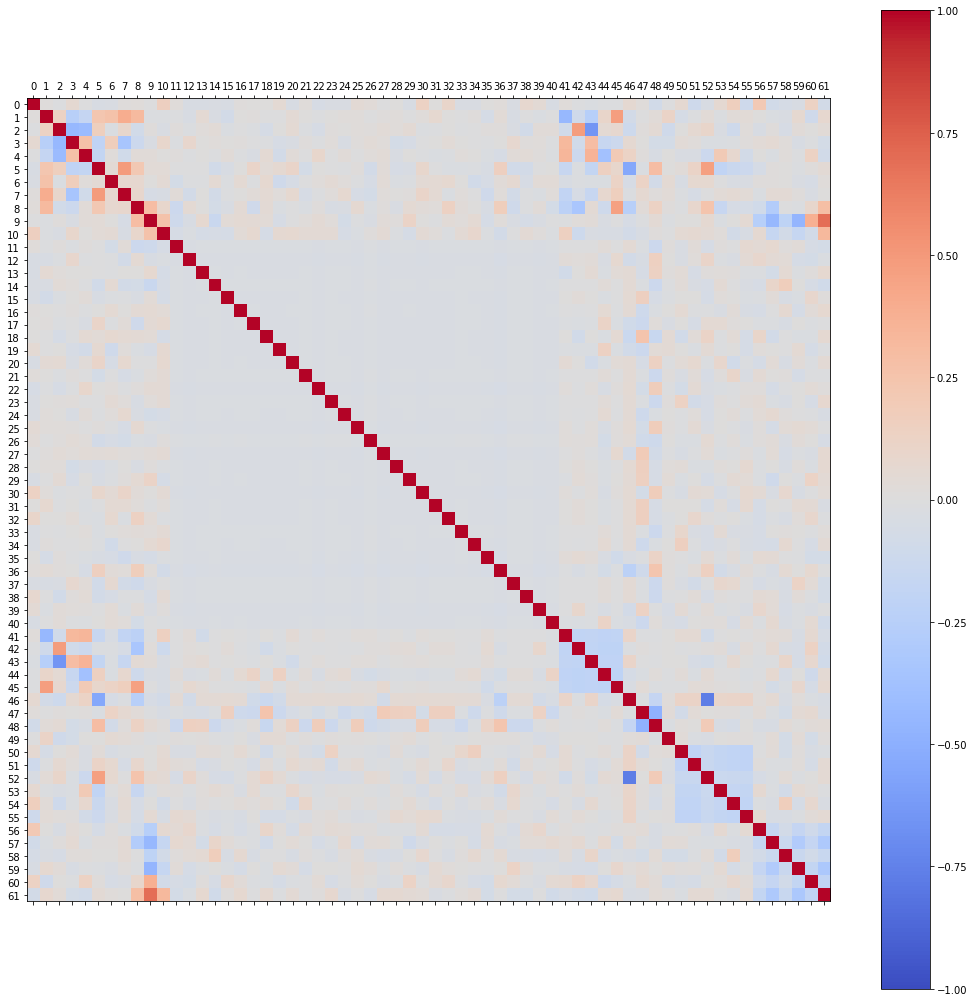

In [12]:

fig = plt.figure(figsize=(18,18))

ax = fig.add_subplot(111)

cax = ax.matshow(cor, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

ticks = np.arange(0,len(final_8.columns),1)

ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()


# Looking at the dependent variable to understand its distribution

In [13]:
# checking the dependent variable for outliers

X = final_8['Attendance']
X_log = np.log(X)

print(final_8['Attendance'].describe())
print('---------------------------------------------')
print('Stats for log_transformed dependent variable')
print('---------------------------------------------')
print(X_log.describe())

count      522.000000
mean     15990.867816
std       1790.090443
min       8832.000000
25%      15131.000000
50%      16219.000000
75%      17280.250000
max      19904.000000
Name: Attendance, dtype: float64
---------------------------------------------
Stats for log_transformed dependent variable
---------------------------------------------
count    522.000000
mean       9.672897
std        0.120506
min        9.086137
25%        9.624501
50%        9.693939
75%        9.757320
max        9.898676
Name: Attendance, dtype: float64


Looking at the median value, we can see that the dependent variable is a bit skewed. Looking at the scaled and unscaled ditribution for the dependent variable


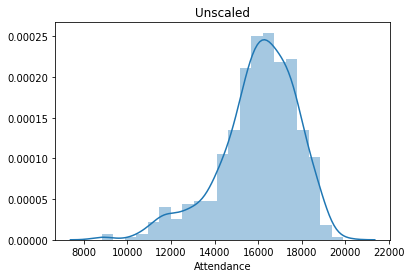

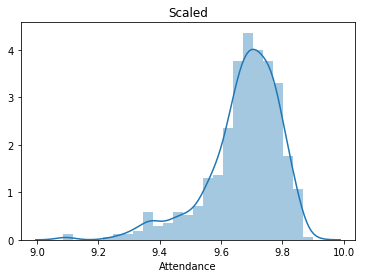

In [36]:

sns.distplot(X).set_title('Unscaled')
plt.show()

sns.distplot(X_log).set_title('Scaled')
plt.show()


We can think of log transformation for the dependent variable and check the predictions, if it can help in improving accuracy of the model


To Check for Multivariate Normality

There are a number of techniques that you can check if your data sample is Gaussian or sufficiently Gaussian-like to 
use the standard techniques, or sufficiently non-Gaussian to instead use non-parametric statistical methods.

There is also some middle ground where we can assume that the data is Gaussian-enough to use parametric methods or that we can use data preparation techniques to transform the data to be sufficiently Gaussian to use the parametric methods.

2 common methods to visually check if the data is drawn from a gaussian distribution or not are histograms and Q-Q plots


D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


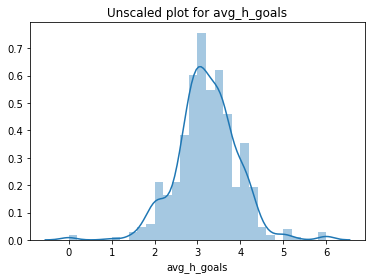

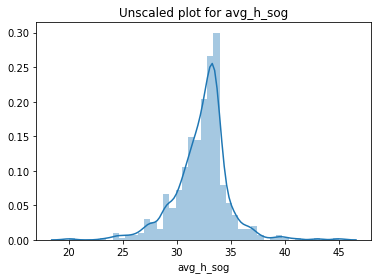

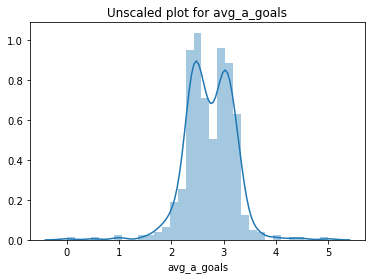

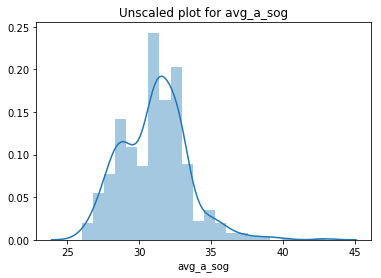

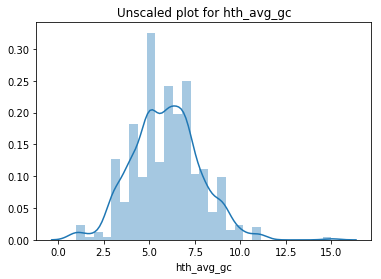

D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


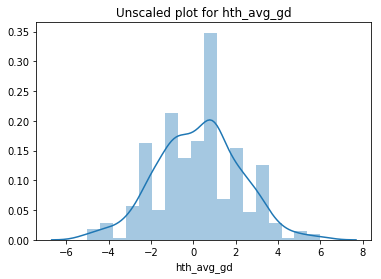

In [32]:

# Histograms for all the independent variables to check for normal distribution

cols = ['avg_h_goals', 'avg_h_sog',
      'avg_a_goals', 'avg_a_sog', 'hth_avg_gc', 'hth_avg_gd']

for col in cols:
    X = final_8[col]
    log_X = np.log(X)
    sns.distplot(X).set_title("Unscaled plot for " + col)
    plt.show()
    

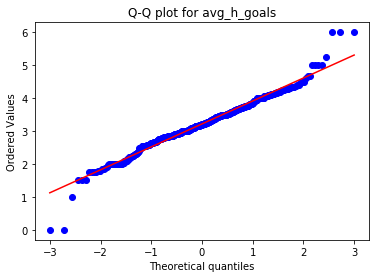

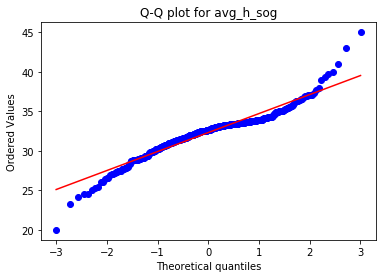

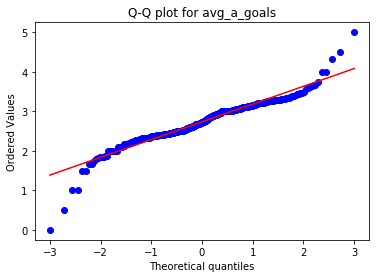

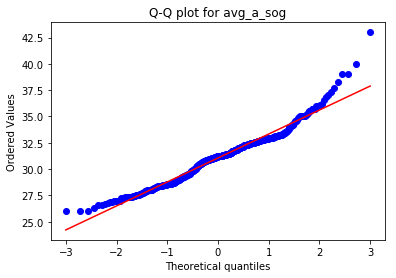

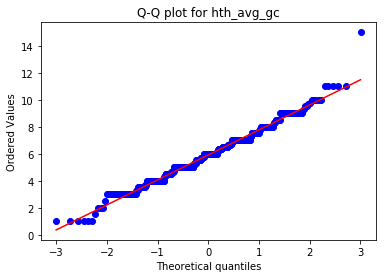

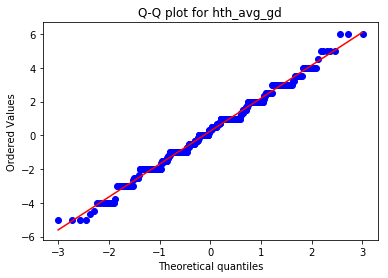

In [33]:
# Quantile-Quantile plots

import pylab 
import scipy.stats as stats

cols = ['avg_h_goals', 'avg_h_sog',
      'avg_a_goals', 'avg_a_sog', 'hth_avg_gc', 'hth_avg_gd']

for col in cols:
    stats.probplot(final_8[col], dist='norm', plot=pylab)
    pylab.title("Q-Q plot for " + col)
    pylab.show()


Looking at the distribution of all the features

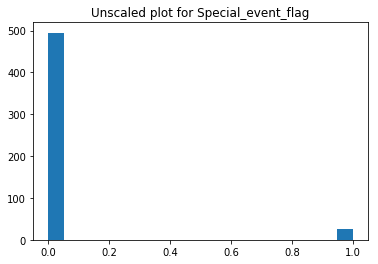

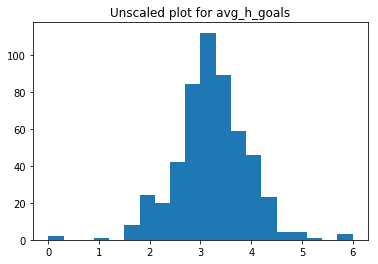

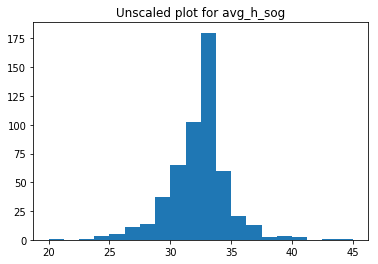

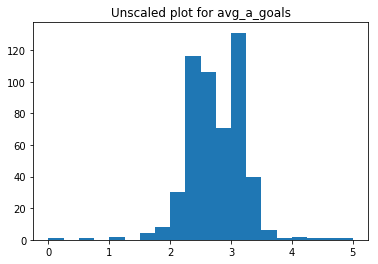

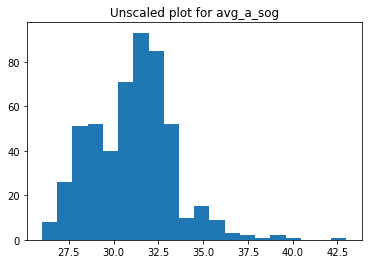

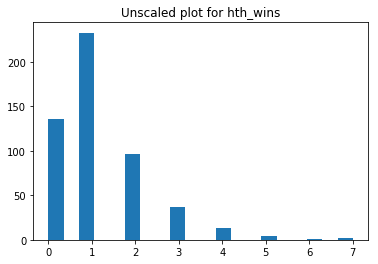

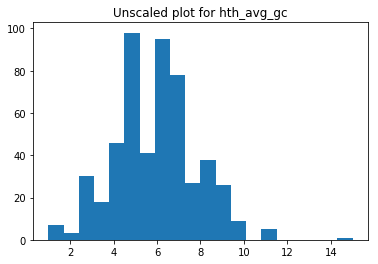

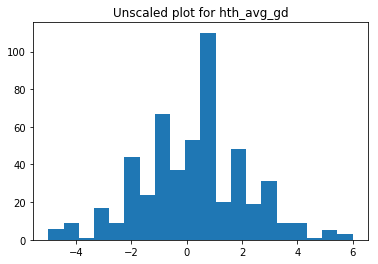

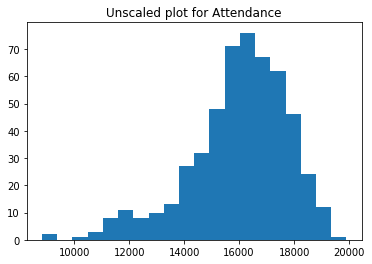

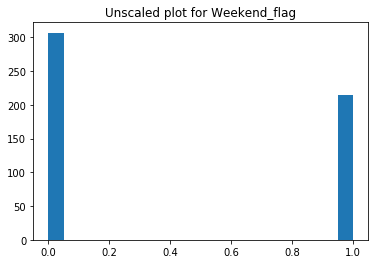

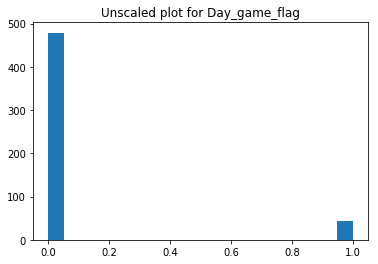

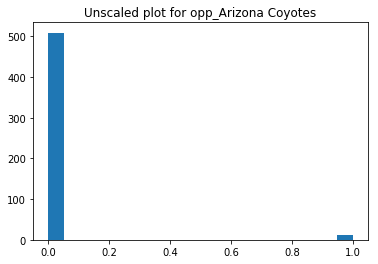

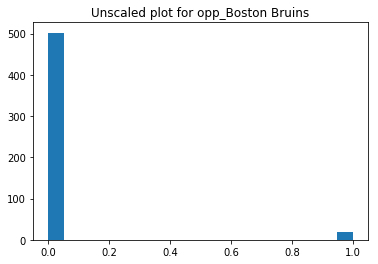

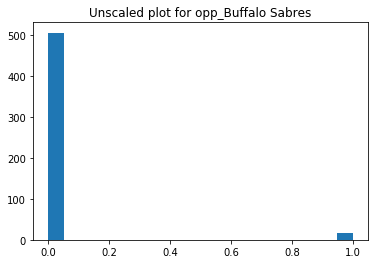

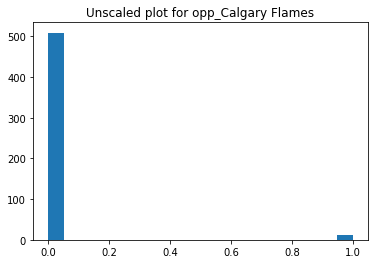

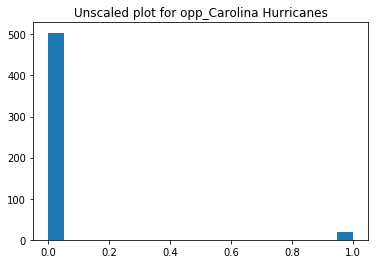

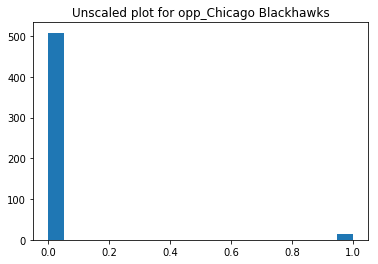

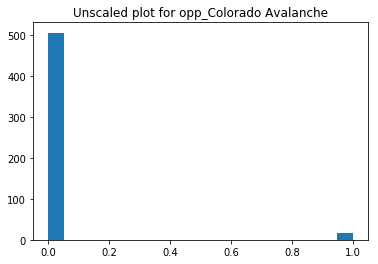

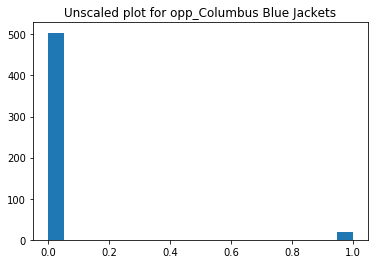

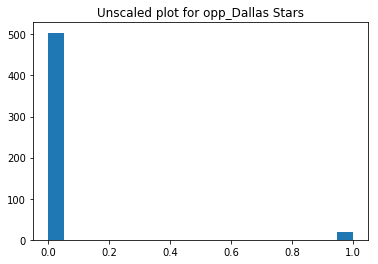

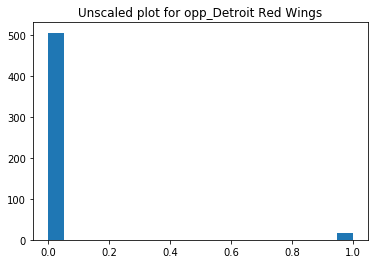

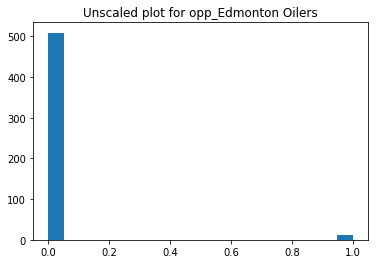

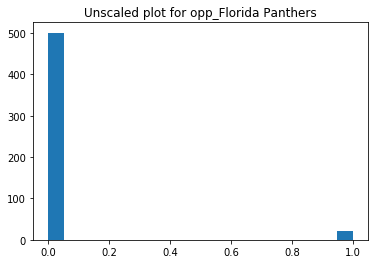

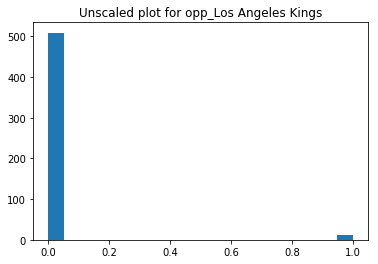

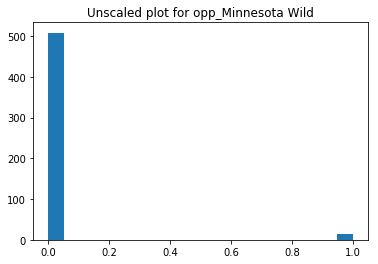

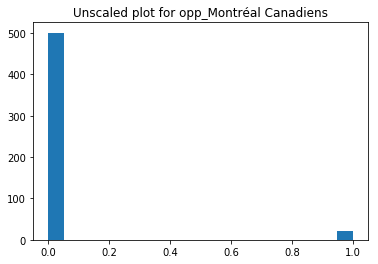

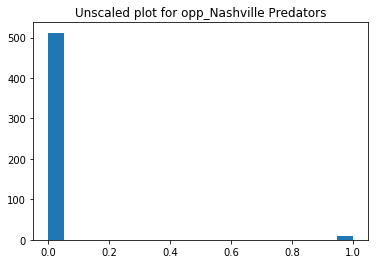

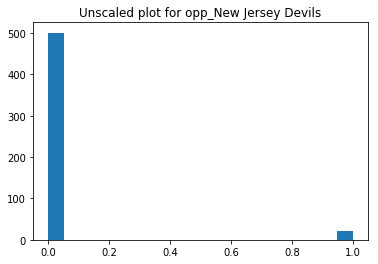

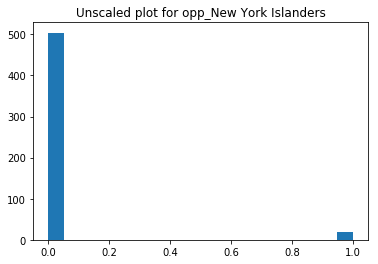

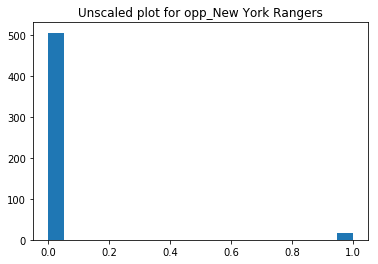

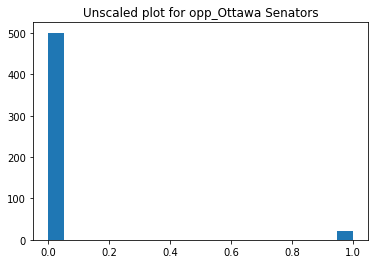

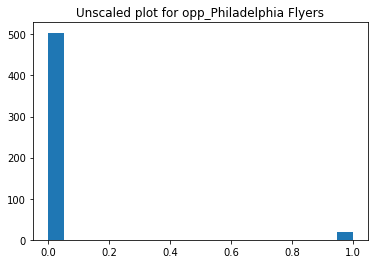

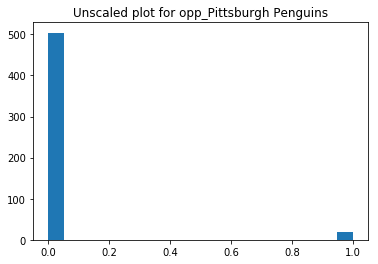

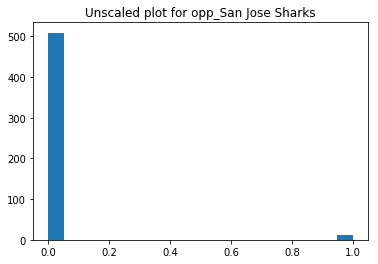

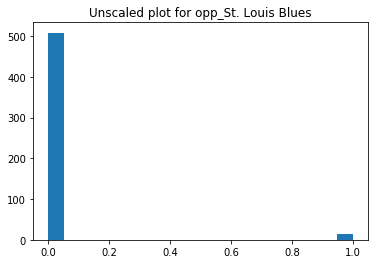

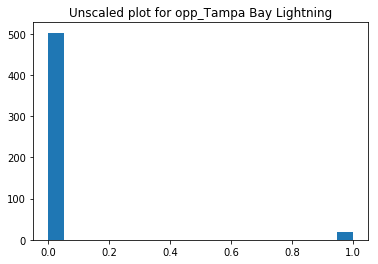

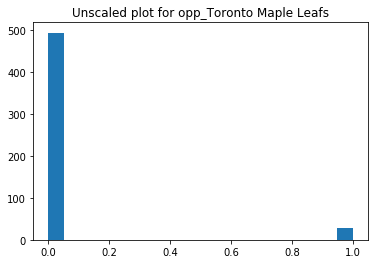

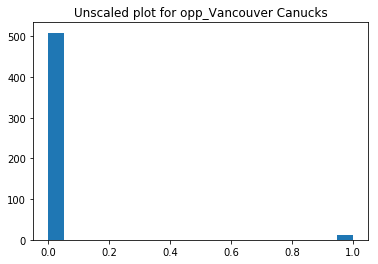

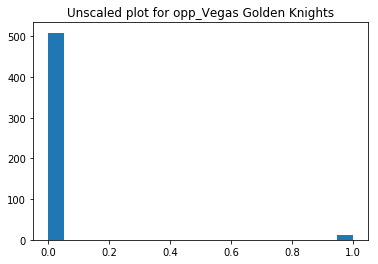

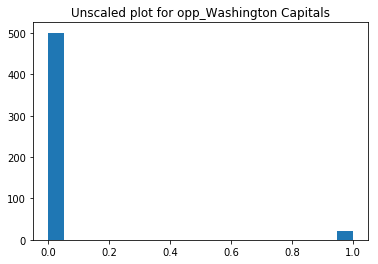

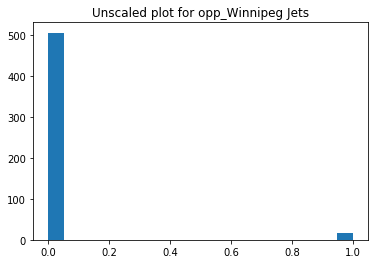

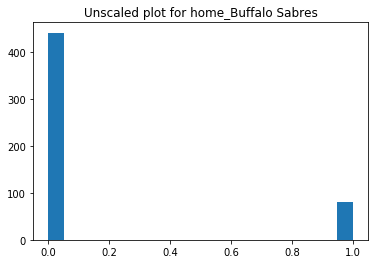

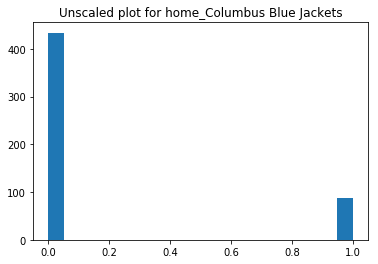

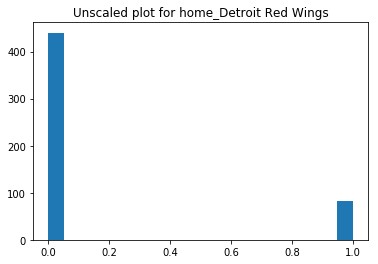

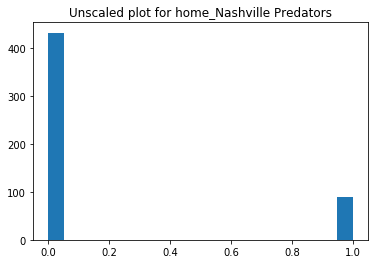

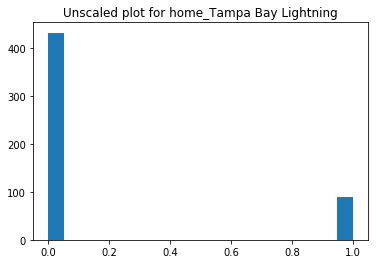

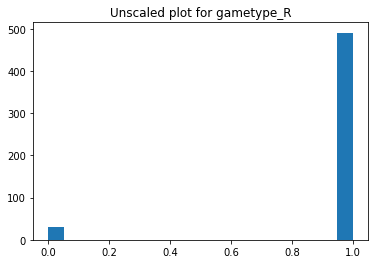

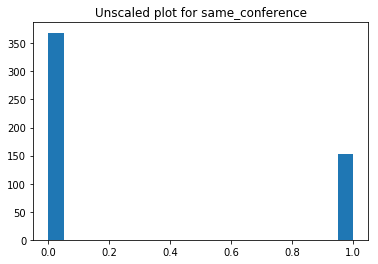

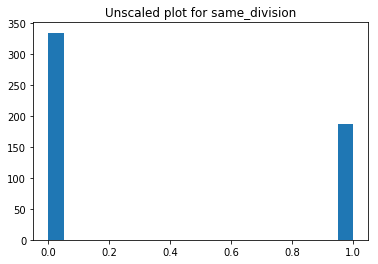

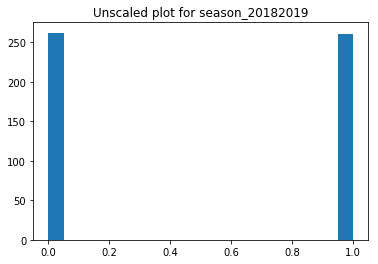

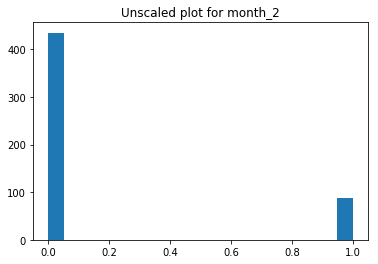

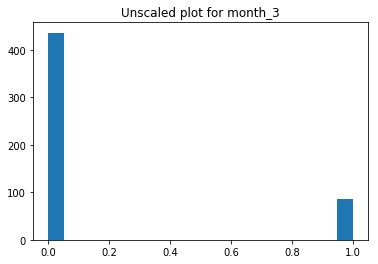

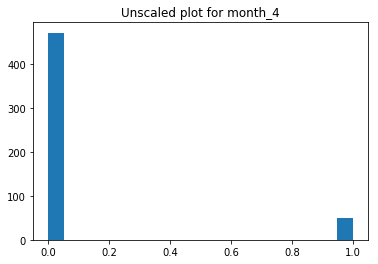

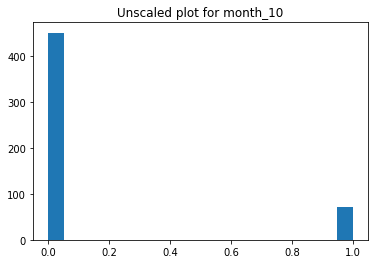

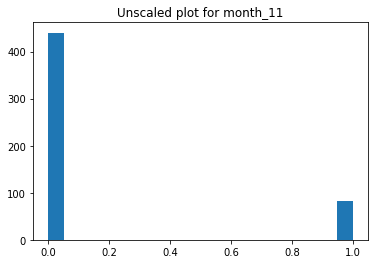

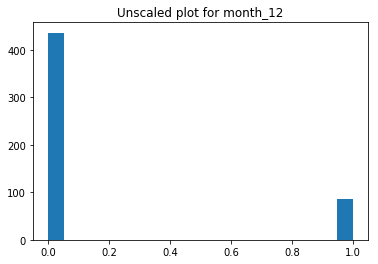

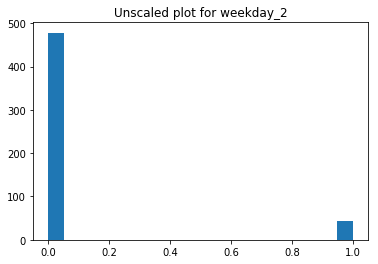

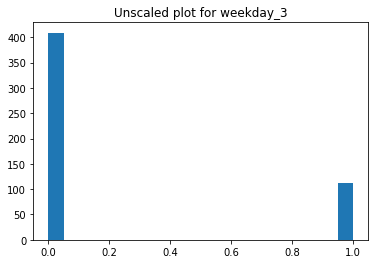

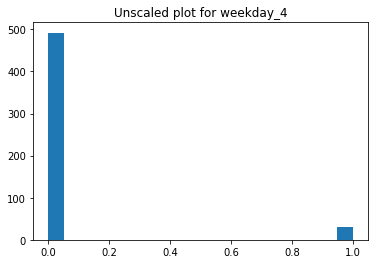

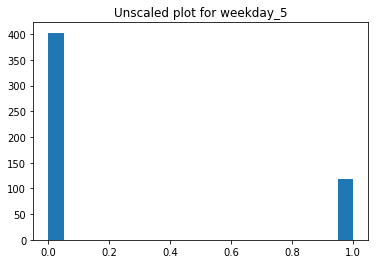

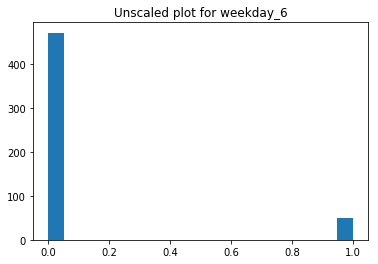

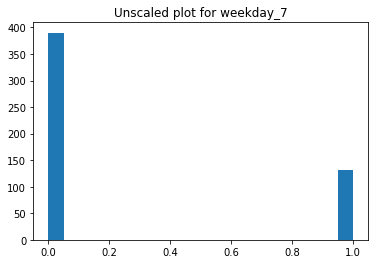

In [15]:

for col in final_8.columns:  
    X = final_8[col]
    plt.hist(X,20)
    plt.title("Unscaled plot for " + col)
    plt.show()


# PreProcessing: 

Standardizing/ Normalizing variables.

Removing the mean and scaling to unit variance.
It is done independently on each feature and mean and std are stored to be used later in the transform method.

Standardization is an important requirement for many machine learning algorithms. They might behave badly if individual features are not almost normal.

If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

3 methods of feature scaling.

StandardScaler
MinMaxScaler
RobustScaler



Set up preliminary data for fitting models, Converting pandas dataframe to a numpy array

In [35]:
final_8.columns

Index(['Special_event_flag', 'avg_h_goals', 'avg_h_sog', 'avg_a_goals',
       'avg_a_sog', 'hth_wins', 'hth_avg_gc', 'hth_avg_gd', 'Attendance',
       'Weekend_flag', 'Day_game_flag', 'opp_Arizona Coyotes',
       'opp_Boston Bruins', 'opp_Buffalo Sabres', 'opp_Calgary Flames',
       'opp_Carolina Hurricanes', 'opp_Chicago Blackhawks',
       'opp_Colorado Avalanche', 'opp_Columbus Blue Jackets',
       'opp_Dallas Stars', 'opp_Detroit Red Wings', 'opp_Edmonton Oilers',
       'opp_Florida Panthers', 'opp_Los Angeles Kings', 'opp_Minnesota Wild',
       'opp_Montréal Canadiens', 'opp_Nashville Predators',
       'opp_New Jersey Devils', 'opp_New York Islanders',
       'opp_New York Rangers', 'opp_Ottawa Senators',
       'opp_Philadelphia Flyers', 'opp_Pittsburgh Penguins',
       'opp_San Jose Sharks', 'opp_St. Louis Blues', 'opp_Tampa Bay Lightning',
       'opp_Toronto Maple Leafs', 'opp_Vancouver Canucks',
       'opp_Vegas Golden Knights', 'opp_Washington Capitals',
       'op

# Fitting a Multiple Linear Regression model on our data.

We start by applying a simple multiple linear regression, to understand if the relation between the independent and dependent variables is linear, and if the variance in the dependent variable can be explained linearly by the independent variables or not.

Converting dataframe into a numpy array with attendance (target) as the first column and other features as the subsequent columns

In [36]:

prelim_model_data = np.array([final_8['Attendance'],
                              final_8['month_2'], final_8['month_3'], final_8['month_4'], 
                              final_8['month_10'], final_8['month_11'], final_8['month_12'],
                              final_8['weekday_2'], final_8['weekday_3'], final_8['weekday_4'], final_8['weekday_5'],
                              final_8['weekday_6'], final_8['weekday_7'], 
                              final_8['Special_event_flag'], final_8['avg_h_goals'],
                              final_8['avg_h_sog'], final_8['avg_a_goals'], final_8['avg_a_sog'], final_8['hth_wins'],
                              final_8['hth_avg_gc'], final_8['hth_avg_gd'], final_8['Weekend_flag'],
                              final_8['Day_game_flag'], final_8['opp_Arizona Coyotes'],
                              final_8['opp_Boston Bruins'], final_8['opp_Buffalo Sabres'],
                              final_8['opp_Calgary Flames'], final_8['opp_Carolina Hurricanes'],
                              final_8['opp_Chicago Blackhawks'], final_8['opp_Colorado Avalanche'], 
                              final_8['opp_Columbus Blue Jackets'], final_8['opp_Dallas Stars'],
                              final_8['opp_Detroit Red Wings'], final_8['opp_Edmonton Oilers'],
                              final_8['opp_Florida Panthers'], final_8['opp_Los Angeles Kings'],
                              final_8['opp_Minnesota Wild'], final_8['opp_Montréal Canadiens'],
                              final_8['opp_Nashville Predators'], final_8['opp_New Jersey Devils'],
                              final_8['opp_New York Islanders'], final_8['opp_New York Rangers'],
                              final_8['opp_Ottawa Senators'], final_8['opp_Philadelphia Flyers'], 
                              final_8['opp_Pittsburgh Penguins'], final_8['opp_San Jose Sharks'],
                              final_8['opp_St. Louis Blues'], final_8['opp_Tampa Bay Lightning'],
                              final_8['opp_Toronto Maple Leafs'], final_8['opp_Vancouver Canucks'], 
                              final_8['opp_Vegas Golden Knights'], final_8['opp_Washington Capitals'],
                              final_8['opp_Winnipeg Jets'],
                              final_8['home_Buffalo Sabres'], final_8['home_Columbus Blue Jackets'], 
                              final_8['home_Detroit Red Wings'], final_8['home_Nashville Predators'],
                              final_8['home_Tampa Bay Lightning'], final_8['gametype_R'],
                              final_8['same_conference'], final_8['same_division'],
                              final_8['season_20182019']]).T

prelim_model_data.shape

(522, 62)

# Train and Test Split

It is important to apply transform only on the training data. If we apply on the entire dataset, 
there's something called data leakage that happens. The model then knows something about the test set and hence won't do
that well. Because when the model is not completely blind to the data.

Splitting the data into test and train and then transforming the train dataset before applying the model


In [37]:

X_train, X_test, Y_train, Y_test = train_test_split(prelim_model_data[:,1:62], prelim_model_data[:,0],
                                                    test_size=0.3, random_state=100)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(365, 61)
(157, 61)
(365,)
(157,)


In [38]:
final_8.head()

,Special_event_flag,avg_h_goals,avg_h_sog,avg_a_goals,avg_a_sog,hth_wins,hth_avg_gc,hth_avg_gd,Attendance,Weekend_flag,Day_game_flag,opp_Arizona Coyotes,opp_Boston Bruins,opp_Buffalo Sabres,opp_Calgary Flames,opp_Carolina Hurricanes,opp_Chicago Blackhawks,opp_Colorado Avalanche,opp_Columbus Blue Jackets,opp_Dallas Stars,opp_Detroit Red Wings,opp_Edmonton Oilers,opp_Florida Panthers,opp_Los Angeles Kings,opp_Minnesota Wild,opp_Montréal Canadiens,opp_Nashville Predators,opp_New Jersey Devils,opp_New York Islanders,opp_New York Rangers,opp_Ottawa Senators,opp_Philadelphia Flyers,opp_Pittsburgh Penguins,opp_San Jose Sharks,opp_St. Louis Blues,opp_Tampa Bay Lightning,opp_Toronto Maple Leafs,opp_Vancouver Canucks,opp_Vegas Golden Knights,opp_Washington Capitals,opp_Winnipeg Jets,home_Buffalo Sabres,home_Columbus Blue Jackets,home_Detroit Red Wings,home_Nashville Predators,home_Tampa Bay Lightning,gametype_R,same_conference,same_division,season_20182019,month_2,month_3,month_4,month_10,month_11,month_12,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,0,2.00,45.000000,3.000000,40.000000,0,5.0,-1.0,17285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,2.00,35.000000,4.500000,35.500000,0,8.0,-4.0,14900,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0,2.00,30.666667,4.333333,37.333333,0,6.0,-2.0,15715,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,0,1.75,31.000000,3.250000,36.000000,1,1.0,1.0,14417,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0,1.80,31.400000,3.200000,35.000000,0,5.0,-1.0,16088,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [39]:

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import Normalizer

scaler1 = StandardScaler()
# scaler2 = MinMaxScaler()
# scaler3 = Normalizer()

X_train_transformed = scaler1.fit_transform(X_train)

# print(X_train_transformed)
#print(Y_train_transformed)
#print(Y_train.shape)


Create a linear regression object

In [40]:

reg = linear_model.LinearRegression(fit_intercept = True, normalize = False)



Fit_intercept - Calculate intercept for this model (False when data is expected to be centered) (False will set y-intercept to 0, true then y-intercept will be determinded by the line of best fit)

Normalize - Regressors X will be normalized, subtract meand and divide by l2 norm (use standardscaler and set ot false)


# Fitting the model on training data

In [41]:
reg.fit(X_train_transformed,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Looking at the coefficients

In [42]:

reg.coef_.tolist()


[39.70745554060243,
 86.38353058054041,
 179.24999044230123,
 -298.5976285149155,
 -175.2598574868166,
 -69.23046666614013,
 268.52743334069294,
 291.38440121243093,
 339.55480096028344,
 515.4559296167167,
 318.0626075944518,
 351.95201842668774,
 40.830602903500264,
 85.01734482387657,
 -33.80669241106635,
 -36.35201773363772,
 73.53953127868992,
 -116.25298138556826,
 -44.23940994374556,
 -3.673501091381695,
 604.7483781474466,
 38.68765374674044,
 -51.242828945992784,
 108.15691812784456,
 -8.517113404539131,
 50.77831914033678,
 -15.344508486917448,
 116.41503316386823,
 -120.99943761194777,
 -27.504997525363535,
 -7.031060350123433,
 44.600245088905695,
 81.51391867004415,
 83.2781764918474,
 50.87943808640662,
 72.45779278326563,
 179.37437583186113,
 58.25465266501743,
 -43.532799544402565,
 64.30825913350941,
 55.407438801804275,
 87.21666384373918,
 134.67677486723656,
 335.8514815077536,
 115.54563468196176,
 65.83409002546641,
 81.56059654138596,
 226.38291579874652,
 9.579

Applying the model on the test set, to get the predictions

In [43]:
y_pred = reg.predict(X_test)

print(Y_test)
print(y_pred)


[16798. 17492. 13650. 16086. 18768. 17229. 11806. 16738. 16272. 15227.
 17058. 16570. 17734. 18644. 13371. 14953. 16806. 18838. 15753. 16358.
 16284. 15592. 16887. 15420. 17281. 17165. 17025. 15306. 17726. 14813.
 18262. 18003. 17546. 15500. 16398. 13342. 17246. 15885. 15367. 18161.
 14417. 16640. 17010. 15253. 18798. 15881. 14090. 15056. 15618. 17613.
 14934. 12670. 14923. 14818. 17771. 16658. 17591. 18224. 16434. 15834.
 18146. 17487. 16790. 11287. 16200. 12472. 16077. 15494. 14479. 15592.
 15819. 16603. 16341. 18132. 16513. 11566. 18306. 15887. 15740. 14243.
 17432. 15654. 14943. 14676. 13321. 17878. 16645. 15883. 17423. 17241.
 11900. 17774. 13965. 12912. 15417. 14896. 14438. 17709. 15441. 11878.
 16147. 14900. 17480. 18492. 18146. 15020. 15695. 13365. 16261. 16756.
 16833. 13868. 16432. 17217. 14630. 15302. 18635. 15775. 17335. 16273.
 18140. 15912. 15695. 15796. 16532. 15840. 16174. 12753. 14708. 16287.
 17542. 16091. 14380. 15894. 18460. 16596. 15234. 18345. 15756. 15952.
 17656

# Evaluating model performance by looking at RMSE and R squared

In [44]:

rmse = sqrt(mean_squared_error(Y_test, y_pred))
r2 = reg.score(X_test,Y_test)
print('Root Mean Squared Error:', rmse)
print('R Squared', r2)


Root Mean Squared Error: 1840.2106886663803
R Squared -0.12337214818749342


Looking at the R^2 value, indicates that may be the relationship between dependent and independent variable is not linear, we will now apply cross validation and regularizations to further deep dive

# Residual Plot to check for homoscedasticity/ heteroscedasticity

Text(0.5, 1.0, 'Residual plot')

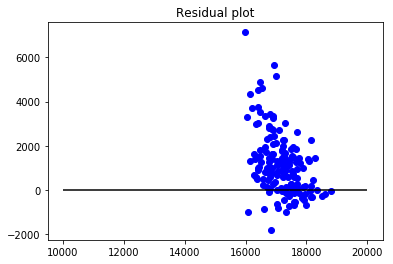

In [45]:

x_plot = plt.scatter(y_pred, (y_pred - Y_test), c='b')

plt.hlines(y=0, xmin= 10000, xmax=20000)

plt.title('Residual plot')



Heteroscedasticity is all about checking for randomness in the residuals.

Non-constant variance in error terms results in heteroscedasticity. Non-constant variance arises in presence of outliers.
These values get too much weight and thereby disproportionately influencing model's perfromance.

If there is a funnel shape, or a linear relation, then heteroscedsticity exists.
This indicates signs of non linearity in the data that has not been captured.

The plot above has enough randomness so we should not have much problem for heteroscedasticity



# Variance Inflation Factor - Multicollinearity

Colinearity is when 2 variables are highly correlated and contain similar information about the variance within a given dataset. Mullticolinearity is when there are 3 or more variables that are highly correlated.

Variance Inflation Factor is a measure of colinearity among predictors in a multiple regression model.
Calculated by taking ratio of variance of all given model's betas divide by the variance of a single beta if it were fit alone.

If VIf values are between 5-10, multicolinearity is likely present and should consider dropping the variable.

Calculating the Variance Inflation Factor

Colinearity can only be checked for continuous variables. So we only need to look at the vif factors for continuous variable.

In [46]:

# for each X, we need to calculate VIF and store it in a dataframe.

vif_data = final_8[['avg_h_goals', 'avg_h_sog', 'avg_a_goals', 'avg_a_sog', 'hth_wins', 'hth_avg_gc', 'hth_avg_gd']]
vif_data_1 = add_constant(vif_data)
vif = pd.DataFrame()

vif['VIF Factor'] = [variance_inflation_factor(vif_data_1.values,i) for i in range(vif_data_1.shape[1])]
vif['Features'] = vif_data_1.columns


D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [47]:
pd.options.display.max_rows = None

vif

,VIF Factor,Features
0,792.800945,const
1,1.331291,avg_h_goals
2,1.434836,avg_h_sog
3,1.518339,avg_a_goals
4,1.256342,avg_a_sog
5,1.358917,hth_wins
6,1.151374,hth_avg_gc
7,1.606815,hth_avg_gd



Using k-fold Cross-Validation 


Kfold creates an instance that splits the data into k folds shuffles prior to the split (True or False) and a seed used prior to the split

In [48]:
kfold = 10

# Preparing cross validation

kf = KFold(n_splits=kfold, shuffle= True, random_state= 1)

Split() function calls the data sample. It will return each group of train and test sets. Specifically, arrays are returned containing indices into the original data sample of observations to use for train and test for each iteration.


In [49]:
# Enumerate splits
rmse_mean = []
r2_scores = []
for train_indices, test_indices in kf.split(prelim_model_data):
    #print('Train indices: %s, Test indices: %s' % (train, test))
    X_train = prelim_model_data[train_indices,1:62]
    Y_train = prelim_model_data[train_indices,0]
    X_test = prelim_model_data[test_indices,1:62]
    Y_test = prelim_model_data[test_indices,0]
    
    X_train_trans = scaler1.fit_transform(X_train)
    reg.fit(X_train_trans,Y_train)
    y_pred = reg.predict(X_test)
    rmse = sqrt(mean_squared_error(Y_test,y_pred))
    r2 = reg.score(X_test,Y_test)
#    print('rmse: ', rmse)
#    print('Variance score ', r2)
    rmse_mean.append(rmse)
    r2_scores.append(r2)
print('Results for 10 fold Cross Validation')
print('Mean rmse for 10 fold CV ', np.mean(rmse_mean))
print('mean r2 score for 10 fold cross validation', np.mean(r2_scores))

Results for 10 fold Cross Validation
Mean rmse for 10 fold CV  77635278548150.42
mean r2 score for 10 fold cross validation -1.556310747017766e+22


# RIDGE REGRESSION & LASSO

Fit the model for different values of alpha and plotting it against RMSe values to find the best alpha

# RIDGE REGRESSSION

D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.77588e-18): result may not be accurate.
  overwrite_a=True).T


[1135.3883842097812, 1135.80578736395, 1136.4541931713259, 1137.2150944616537, 1138.053769009517, 1138.954664419264, 1139.908480518322, 1140.908756628894, 1141.9506365542074, 1143.0302831653282, 1144.1445485020088, 1145.2907694890334, 1146.4666349336555, 1147.6700963669207, 1148.8993070685813, 1150.1525796782976, 1151.4283562686207, 1152.725186875607, 1154.041713827312, 1155.3766600829508]
[1313.5178984950612, 1309.8604177703685, 1307.4239161370401, 1305.4270483719824, 1303.7278945031012, 1302.258609792684, 1300.9779365222473, 1299.857692517174, 1298.877259967525, 1298.0208315436098, 1297.2758534506017, 1296.632072407788, 1296.0809194532983, 1295.6150950216347, 1295.2282804317742, 1294.914931829953, 1294.670129565985, 1294.4894657877019, 1294.3689589634291, 1294.304987746721]


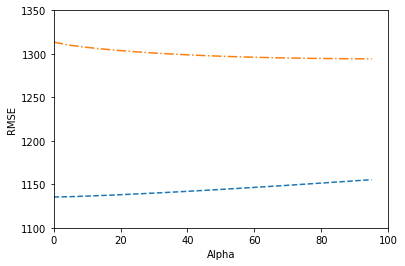

In [51]:

kf = KFold(n_splits=10, shuffle= True, random_state= 1)
alphas = [int(x) for x in range(0,100,5)]

rmse_train_all = []
rmse_test_all = []
alpha_list = []

for al in alphas:

    model = Ridge(alpha=al, solver = 'auto', fit_intercept = True, normalize = False, random_state = al)

    rmse_train_list = []
    rmse_test_list = []
    for train_indices, test_indices in kf.split(prelim_model_data):
        X_train = prelim_model_data[train_indices,1:62]
        Y_train = prelim_model_data[train_indices,0]
        X_test = prelim_model_data[test_indices,1:62]
        Y_test = prelim_model_data[test_indices,0]

        steps = [('scaler', StandardScaler()), ('mod', model)]
        pipe = Pipeline(steps)
        pipe_1 = pipe.fit(X_train, Y_train)
        y_train_pred = pipe_1.predict(X_train)       
        y_test_pred = pipe_1.predict(X_test)
        rmse_train = sqrt(mean_squared_error(Y_train,y_train_pred))
        rmse_test = sqrt(mean_squared_error(Y_test,y_test_pred))        

        rmse_train_list.append(rmse_train)
        rmse_test_list.append(rmse_test)
    rmse_train_all.append(np.mean(rmse_train_list))
    rmse_test_all.append(np.mean(rmse_test_list))       
    alpha_list.append(al)
    
    
print(rmse_train_all)
print(rmse_test_all)
# print(alpha_list)    
    

plt.plot(alpha_list, rmse_train_all, '--')
plt.plot(alpha_list, rmse_test_all, '-.')
plt.axis([0,100,1100,1350])
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.show()


# LASSO

D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the Linear

[1135.3884246070852, 1136.4105688796271, 1137.6458423616764, 1139.0531394476889, 1140.7507571839094, 1142.679650596439, 1144.8621924633753, 1147.2364323846728, 1149.8081133265155, 1152.5129192540421, 1155.4010532277805, 1158.4800192131108, 1161.7264682451473, 1165.1243639964216, 1168.6457216950826, 1172.3008937325865, 1176.05485769404]
[1314.1644137740063, 1305.9792764804042, 1300.0127041947767, 1294.8323172055118, 1290.3649423018414, 1286.3618972707557, 1282.82649517726, 1280.0577772654558, 1277.7931815714157, 1276.1506952411828, 1274.8985846671114, 1274.0069390842746, 1273.464001677811, 1273.2718063959514, 1273.3432363360112, 1273.875850716629, 1274.7802264322384]


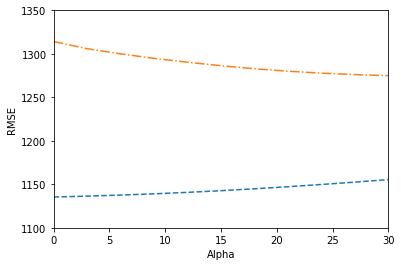

In [53]:

kf = KFold(n_splits=10, shuffle= True, random_state= 1)
alphas = [int(x) for x in range(0,50,3)]

rmse_train_all = []
rmse_test_all = []
alpha_list = []

for al in alphas:

    model = Lasso(alpha=al, fit_intercept = True, normalize = False, random_state = al)

    rmse_train_list = []
    rmse_test_list = []
    for train_indices, test_indices in kf.split(prelim_model_data):
        X_train = prelim_model_data[train_indices,1:62]
        Y_train = prelim_model_data[train_indices,0]
        X_test = prelim_model_data[test_indices,1:62]
        Y_test = prelim_model_data[test_indices,0]

        steps = [('scaler', StandardScaler()), ('mod', model)]
        pipe = Pipeline(steps)
        pipe_1 = pipe.fit(X_train, Y_train)
        y_train_pred = pipe_1.predict(X_train)       
        y_test_pred = pipe_1.predict(X_test)
        rmse_train = sqrt(mean_squared_error(Y_train,y_train_pred))
        rmse_test = sqrt(mean_squared_error(Y_test,y_test_pred))        

        rmse_train_list.append(rmse_train)
        rmse_test_list.append(rmse_test)
    rmse_train_all.append(np.mean(rmse_train_list))
    rmse_test_all.append(np.mean(rmse_test_list))       
    alpha_list.append(al)
    
    
print(rmse_train_all)
print(rmse_test_all)
# print(alpha_list)    
    

plt.plot(alpha_list, rmse_train_all, '--')
plt.plot(alpha_list, rmse_test_all, '-.')
plt.axis([0,30,1100,1350])
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.show()


 # Using GridSearch to find best parameters for Ridge and Lasso

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

X_train, X_test, Y_train, Y_test = train_test_split(prelim_model_data[:,1:62], prelim_model_data[:,0],
                                                    test_size=0.3, random_state=10)

ridge = Ridge(random_state = 42)

alpha = [int(x) for x in np.linspace(start = 0, stop = 40, num = 40) ]
solver = ['auto', 'cholesky']
fit_intercept = [True]
normalize = [True, False]
parameter_list = {'alpha': alpha,
                 'solver': solver,
                 'fit_intercept': fit_intercept,
                 'normalize': normalize}


pipe = Pipeline(steps = [('scaler', StandardScaler()), ('ridge', ridge)])

grid = GridSearchCV(estimator = ridge,  param_grid = parameter_list,  cv=5)
grid.fit(X_train, Y_train)

print(grid.best_params_)
print(grid.best_estimator_)


D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.26881e-17): result may not be accurate.
  overwrite_a=True).T
D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.00994e-17): result may not be accurate.
  overwrite_a=True).T
D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.26881e-17): result may not be accurate.
  overwrite_a=True).T
D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.00994e-17): result may not be accurate.
  overwrite_a=True).T
D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (

{'alpha': 8, 'fit_intercept': True, 'normalize': False, 'solver': 'auto'}
Ridge(alpha=8, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)


# Using pipeline along with cross validation

Making use of pipeline

Pipeline helps in creating a standard sequence of steps to be applied. When we use a pipeline. We are creating a sequence in which we want our model to run. 
For each split, we initially apply transformation to the training set, then we fit the model on the transformed training set. The parameters for transformation (mean and standard deviation) are stored in the model.
Now when we predict on the test set, we don't calculate a new set of values for transofrmation, that will create all together a new variable. We use the same parameters from of the train set and then transform and then make predictions

In our case we first transform our training set, then apply the model using k-fold cross validation and then predict on the test set

Below, we apply linear regression, ridge, lasso and the default random forest models to compare their performances


In [40]:

models = [linear_model.LinearRegression(fit_intercept = True, normalize = False),
         Ridge(alpha=8, solver = 'auto', fit_intercept = True, normalize = False, random_state = 42),
         Lasso(alpha=10, fit_intercept = True, normalize = False),
         RandomForestRegressor(n_estimators=100, random_state=10)]

for mod in models:
    rmse_train_list = []
    rmse_test_list = []
    r2_train_list = []
    r2_test_list = []
    mape_train_list = []
    mape_test_list = []
    for train_indices, test_indices in kf.split(prelim_model_data):
        X_train = prelim_model_data[train_indices,1:62]
        Y_train = prelim_model_data[train_indices,0]
        X_test = prelim_model_data[test_indices,1:62]
        Y_test = prelim_model_data[test_indices,0]
        
        steps = [('scaler', StandardScaler()), ('mod', mod)]
        pipe = Pipeline(steps)
        pipe_1 = pipe.fit(X_train, Y_train)
        y_train_pred = pipe_1.predict(X_train)       
        y_test_pred = pipe_1.predict(X_test)
        rmse_train = sqrt(mean_squared_error(Y_train,y_train_pred))
        rmse_test = sqrt(mean_squared_error(Y_test,y_test_pred))        
        r2_train = pipe_1.score(X_train,Y_train)
        r2_test = pipe_1.score(X_test,Y_test)        
        mape_train = np.mean(((abs(Y_train - y_train_pred))/ Y_train))        
        mape_test = np.mean(((abs(Y_test - y_test_pred))/ Y_test))        
       
        rmse_train_list.append(rmse_train)
        rmse_test_list.append(rmse_test)
        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)
        mape_train_list.append(mape_train)
        mape_test_list.append(mape_test)        

    print('---------------------------------------')
    print('Model performance:')
    print('RMSE for training set: ', np.mean(rmse_train_list))
    print('RMSE for testing set: ', np.mean(rmse_test_list))    
    print('R Squared for training set: ', np.mean(r2_train_list))
    print('R Squared for test set: ', np.mean(r2_test_list))    
    print('Mean Absolute Percentage Error for training set: ', np.mean(mape_train_list)*100)       
    print('Mean Absolute Percentage Error for test set: ', np.mean(mape_test_list)*100)    
    

---------------------------------------
Model performance:
RMSE for training set:  1135.3888791981421
RMSE for testing set:  24338688474804.45
R Squared for training set:  0.5967193105186988
R Squared for test set:  -1.529580820165618e+21
Mean Absolute Percentage Error for training set:  5.546112358099682
Mean Absolute Percentage Error for test set:  19295499766.577026
---------------------------------------
Model performance:
RMSE for training set:  1136.1779950642422
RMSE for testing set:  1308.3324635594968
R Squared for training set:  0.596157941294004
R Squared for test set:  0.4418196570731564
Mean Absolute Percentage Error for training set:  5.558384519850707
Mean Absolute Percentage Error for test set:  6.402031925264976
---------------------------------------
Model performance:
RMSE for training set:  1139.5903276271524
RMSE for testing set:  1293.2441577486666
R Squared for training set:  0.5937282669048987
R Squared for test set:  0.4549839681776664
Mean Absolute Percentage 

In [56]:

prelim_model_data = np.array([final_8['Attendance'],
                              final_8['month_2'], final_8['month_3'], final_8['month_4'], 
                              final_8['month_10'], final_8['month_11'], final_8['month_12'],
                              final_8['weekday_2'], final_8['weekday_3'], final_8['weekday_4'], final_8['weekday_5'],
                              final_8['weekday_6'], final_8['weekday_7'], 
                              final_8['Special_event_flag'], final_8['avg_h_goals'],
                              final_8['avg_h_sog'], final_8['avg_a_goals'], final_8['avg_a_sog'], final_8['hth_wins'],
                              final_8['hth_avg_gc'], final_8['hth_avg_gd'], final_8['Weekend_flag'],
                              final_8['Day_game_flag'], final_8['opp_Arizona Coyotes'],
                              final_8['opp_Boston Bruins'], final_8['opp_Buffalo Sabres'],
                              final_8['opp_Calgary Flames'], final_8['opp_Carolina Hurricanes'],
                              final_8['opp_Chicago Blackhawks'], final_8['opp_Colorado Avalanche'], 
                              final_8['opp_Columbus Blue Jackets'], final_8['opp_Dallas Stars'],
                              final_8['opp_Detroit Red Wings'], final_8['opp_Edmonton Oilers'],
                              final_8['opp_Florida Panthers'], final_8['opp_Los Angeles Kings'],
                              final_8['opp_Minnesota Wild'], final_8['opp_Montréal Canadiens'],
                              final_8['opp_Nashville Predators'], final_8['opp_New Jersey Devils'],
                              final_8['opp_New York Islanders'], final_8['opp_New York Rangers'],
                              final_8['opp_Ottawa Senators'], final_8['opp_Philadelphia Flyers'], 
                              final_8['opp_Pittsburgh Penguins'], final_8['opp_San Jose Sharks'],
                              final_8['opp_St. Louis Blues'], final_8['opp_Tampa Bay Lightning'],
                              final_8['opp_Toronto Maple Leafs'], final_8['opp_Vancouver Canucks'], 
                              final_8['opp_Vegas Golden Knights'], final_8['opp_Washington Capitals'],
                              final_8['opp_Winnipeg Jets'],
                              final_8['home_Buffalo Sabres'], final_8['home_Columbus Blue Jackets'], 
                              final_8['home_Detroit Red Wings'], final_8['home_Nashville Predators'],
                              final_8['home_Tampa Bay Lightning'], final_8['gametype_R'],
                              final_8['same_conference'], final_8['same_division'],
                              final_8['season_20182019']]).T


print(prelim_model_data.shape)


(522, 62)


# Random Forest

To look at the available hyperparameters, let's create a random forest and examine the default values.

In [57]:

rf = RandomForestRegressor(random_state = 42)

print(rf.get_params())


{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


To use randomizedSearchCV, Let's create a parameter grid to sample from during fitting n_estimators, max_features, max_depth, min_sample_split, min_sample_leaf, bootstrap 

In [58]:

# Number of trees in Random Forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=2000, num=10)]

#Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1,67, num=30)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True]

# Create a random grid

random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }

print(random_grid)


{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 3, 5, 7, 10, 12, 14, 16, 19, 21, 23, 26, 28, 30, 32, 35, 37, 39, 41, 44, 46, 48, 51, 53, 55, 57, 60, 62, 64, 67], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True]}


In all there are 10*2*5*3*3*1 900 settings, on each iteration, algorithm will choose a different combination of features.

Instantiate the random search and fit.


In [59]:

X_train_full, X_test_full, Y_train_full, Y_test_full = train_test_split(prelim_model_data[:,1:62], prelim_model_data[:,0],
                                                    test_size=0.3, random_state=42)


print(X_train_full.shape)
print(Y_train_full.shape)
print(X_test_full.shape)
print(Y_test_full.shape)


(365, 61)
(365,)
(157, 61)
(157,)


# Create a base model to tune

In [60]:

rf = RandomForestRegressor()

# Randomized search of parameters, using 10 fold cross validation

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter= 100, verbose= 2, 
                               cv= 10, random_state=42 , n_jobs= -1)

# param_distribution = dict of list of parameters to try
# n_iter = number of setttings that are sampled
# n_jobs = no. of jobs to run in parallel, -1 means use all processors


In [61]:
# Fit the random search model on training data with all features

rf_random.fit(X_train_full, Y_train_full)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 335 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 618 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 12.9min finished
D:\Users\PSanghvi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 3, 5, 7, 10, 12, 14, 16, 19, 21, 23, 26, 28, 30, 32, 35, 37, 39, 41, 44, 46, 48, 51, 53, 55, 57, 60, 62, 64, 67], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None

Looking at the best parameters and the best estimator from the RandomizedSearchCV

In [62]:
print(rf_random.best_params_)

print(rf_random.best_estimator_)

{'n_estimators': 1155, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 32, 'bootstrap': True}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=32,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=1155, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [64]:
    
base_model = RandomForestRegressor(n_estimators=100, random_state=10)
base_model.fit(X_train_full, Y_train_full)
y_pred_train = base_model.predict(X_train_full)
y_pred_test = base_model.predict(X_test_full)
rmse_train = sqrt(mean_squared_error(Y_train_full,y_pred_train))
rmse_test = sqrt(mean_squared_error(Y_test_full,y_pred_test))
errors_train = abs(y_pred_train - Y_train_full)
errors_test = abs(y_pred_test - Y_test_full)
mape_train = 100*np.mean(errors_train/Y_train_full)
mape_test = 100*np.mean(errors_test/Y_test_full)
acc = 100 - mape

print('--------------------------------------------------------------------')
print('Model Performance for a base Random Forest')
print('R^2 score for Training Set:', base_model.score(X_train_full, Y_train_full))
print('R^2 score for Test Set: ', base_model.score(X_test_full, Y_test_full))
print('Root Mean Squared Error for training set: ', rmse_train)
print('Root Mean Squared Error for training set: ', rmse_test)
print('Mean Absolute Percentage Error for training set:', mape_train)
print('Mean Absolute Percentage Error for test set:', mape_test)

best_model = rf_random.best_estimator_
y_pred_train = best_model.predict(X_train_full)
y_pred_test = best_model.predict(X_test_full)
rmse_train = sqrt(mean_squared_error(Y_train_full,y_pred_train))
rmse_test = sqrt(mean_squared_error(Y_test_full,y_pred_test))
errors_train = abs(y_pred_train - Y_train_full)
errors_test = abs(y_pred_test - Y_test_full)
mape_train = 100*np.mean(errors_train/Y_train_full)
mape_test = 100*np.mean(errors_test/Y_test_full)

print('--------------------------------------------------------------------')
print('Model Accuracy for a Randomized Search CV Random Forest')
print('R^2 score for Training Set: ', best_model.score(X_train_full, Y_train_full))
print('R^2 score for Test Set: ', best_model.score(X_test_full, Y_test_full))
print('Root Mean Squared Error for training set: ', rmse_train)
print('Root Mean Squared Error for training set: ', rmse_test)
print('Mean Absolute Percentage Error for training set:', mape_train)
print('Mean Absolute Percentage Error for test set:', mape_test)


--------------------------------------------------------------------
Model Performance for a base Random Forest
R^2 score for Training Set: 0.9303100080609571
R^2 score for Test Set:  0.5555333280875216
Root Mean Squared Error for training set:  461.98629839553195
Root Mean Squared Error for training set:  1243.8436317713288
Mean Absolute Percentage Error for training set: 2.2320341610085
Mean Absolute Percentage Error for test set: 6.157500996237757
--------------------------------------------------------------------
Model Accuracy for a Randomized Search CV Random Forest
R^2 score for Training Set:  0.909116920717871
R^2 score for Test Set:  0.5606206655081353
Root Mean Squared Error for training set:  527.5764544907346
Root Mean Squared Error for training set:  1236.7046671684775
Mean Absolute Percentage Error for training set: 2.5473233017361507
Mean Absolute Percentage Error for test set: 6.107757889449539



Looking at the RMSE and MAPE values for the base model and the cross validation model, we notice that the model is overfitting on the training set. This could be because of the opposition categorical variable that has been one hot encoded. That leads to an increase in features by 30, as there are 31 opposition teams

In order to reduce overfitting, we'll look at H2O, random forest in H2O doesn't require one hot encoding for categorical variables and has had improved efficiencies.


In [65]:
feature_list = ['month_2', 'month_3', 'month_4', 'month_10', 'month_11', 'month_12', 'weekday_2', 'weekday_3', 
                'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'Special_event_flag', 'avg_h_goals', 'avg_h_sog',
                'avg_a_goals', 'avg_a_sog', 'hth_wins', 'hth_avg_gc', 'hth_avg_gd', 'Weekend_flag', 'Day_game_flag', 
                'opp_Arizona Coyotes', 'opp_Boston Bruins', 'opp_Buffalo Sabres', 'opp_Calgary Flames',
                'opp_Carolina Hurricanes', 'opp_Chicago Blackhawks', 'opp_Colorado Avalanche', 
'opp_Columbus Blue Jackets', 'opp_Dallas Stars',
'opp_Detroit Red Wings', 'opp_Edmonton Oilers',
'opp_Florida Panthers', 'opp_Los Angeles Kings',
'opp_Minnesota Wild', 'opp_Montréal Canadiens',
'opp_Nashville Predators', 'opp_New Jersey Devils',
'opp_New York Islanders', 'opp_New York Rangers',
'opp_Ottawa Senators', 'opp_Philadelphia Flyers', 
'opp_Pittsburgh Penguins', 'opp_San Jose Sharks',
'opp_St. Louis Blues', 'opp_Tampa Bay Lightning',
'opp_Toronto Maple Leafs', 'opp_Vancouver Canucks', 
'opp_Vegas Golden Knights', 'opp_Washington Capitals',
'opp_Winnipeg Jets',
'home_Buffalo Sabres', 'home_Columbus Blue Jackets', 
'home_Detroit Red Wings', 'home_Nashville Predators',
'home_Tampa Bay Lightning', 'gametype_R',
'same_conference', 'same_division',
'season_20182019']

len(feature_list)

61

In [66]:

importances = best_model.feature_importances_

len(feature_list)


61

In [994]:
feature_importance_df = pd.DataFrame(importances, index=feature_list, columns=['importance']).sort_values('importance',
                                                                                                        ascending=False)
feature_importance_df


,importance
avg_h_sog,0.092935
avg_h_goals,0.091509
home_Tampa Bay Lightning,0.087339
avg_a_goals,0.086196
avg_a_sog,0.054848
home_Columbus Blue Jackets,0.052872
hth_avg_gc,0.040816
Tuesday,0.035384
hth_avg_gd,0.034427
Weekend_flag,0.028711


# Exploring H2O for random forest.